## Correlation

##### Calculation of the correlation between solar wind speed and the total electron content of the ionosphere. Investigation of the variation of the correlation values with time and with latitude. Here an annual variation was discovered in previous studies, which will be proved and investigated by examining a long time series.

### DATA SOURCE
##### Total Electron Content of ionosphere
###### https://cdaweb.gsfc.nasa.gov/pub/data/gps/
##### solar radio flux at 10.7 cm (2800 MHz)
###### ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/wdc/yearly
###### https://www.spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-5-en.php
##### Solar wind speed
###### http://www.srl.caltech.edu/ACE/ASC/level2/lvl2DATA_SWEPAM.html

### ___________________________________________

#### External Libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os
import enum

os.environ["CDF_LIB"] = "C:\cdf3.8.0_64bit_VS2015\lib"
from spacepy import pycdf
from pathlib import Path
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import datetime as dt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

#### Constants

In [129]:
startYear = 1997
endYear = 2020
startDate = str(startYear) + '-01-01'
endDate = str(endYear) + '-12-31'
analysisPeriod = np.arange(startYear, endYear+1)
dateFormat = '%Y-%m-%d'
numberOfDays = numberOfDaysInDates(startDate, endDate)

f10_7_max_value = 300
sws_max_value = 900

windowSize = 27
minPeriod = 20

_attribute = 'attribute'
_start_position = 'start_position'
_end_position = 'end_position'
_date = 'date'
_threshold_value = 'threshold_value'
_date_format = 'date_format'

# ------------------f10.7 variables
_f10_7 = 'f10_7'
_f10_7_ma_27 = 'f10_7_ma_27'
_f10_7_rel_diff = 'f10_7_diff_rel'

# ------------------solar wind speed variables
_sws = 'sws'
_sws_ma_27 = 'sws_ma_27'
_sws_rel_diff = 'sws_diff_rel'

#-------------------total electron content variables


final_plot_location = 'C:/Users/davi_fr/Documents/Thesis Project Final/Final Plot/'

#### Configurations

In [130]:
F10_7_FOLDER = "C:/Users/davi_fr/Documents/Project/data/F10.7cm radiofluxindex/"

# dataPosition variable contain how to extarct data from string based on position and length
# format: [[attribure, start_position, end_position, threshold_value, date_format],...]
# threshold value: 
f10_7DataPosition = [{_attribute: _date, _start_position: 0,  _end_position: 10},
                {_attribute: _f10_7, 
                 _start_position: 149, 
                 _end_position: 156, 
                 _threshold_value: f10_7_max_value, 
                 _date_format: None}]




f10_7_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/f10_7/f10_7.h5'
sws_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/sws/sws.h5'

# final_plot_location = 'C:/Users/davi_fr/Documents/Thesis Project Final/Final Plot/'
final_plot_location = 'C:/Users/davi_fr/Documents/Thesis Project Final/correlation_analysis_01122022/result_plots_2/'

#### Log

In [4]:
def writeToLogFile(log):
    dt = datetime.now()
    log = str(dt) + '\t' + log + '\n' 
    file_name = 'log_file.txt'
    f = open(file_name, 'a+')  # open file in append mode
    f.write(log)
    f.close()

def log(message):
    writeToLogFile(message)
#     print(message)

#### General Functions

In [3]:
# calculates number of days between given dates
# this is used verify there are accurate number of entries in the data set
def numberOfDaysInDates(start, end):
    startDate = datetime.strptime(start, dateFormat)
    endDate = datetime.strptime(end, dateFormat)
    delta = endDate - startDate
    return delta.days + 1


# An empty dataframe is initialised with the given metadata
# attribute name in metadata is used to create the column names
def initDataFrame(metadata):
    columnNames = []
    for element in metadata:
        attribute = element[_attribute] if _attribute in element else ''
        columnNames.append(attribute)   
        
    df = pd.DataFrame(columns=columnNames)
    return df


# extract data values from text lines based on the given meta data
# metadata comprises what is the data, type of the data and positions need to be extracted
# Threshold value: if the attribute value goes beyond thresold value then it is considered as NaN
def extractDataFromTxtLine(txt, metadata):
    value = {}
    for element in metadata:
        attribute = element[_attribute] if _attribute in element else ''
        startPosition = element[_start_position] if _start_position in element else 0
        endPosition = element[_end_position] if _end_position in element else 0
        thresholdValue = element[_threshold_value] if _threshold_value in element else 0
        dataDateFormat = element[_date_format] if _date_format in element else None
        try:
            attrValue = txt[startPosition:endPosition]
            if attrValue == '':
                break
            if thresholdValue != 0:
                try:
                    attrValue = float(attrValue)
                    attrValue = float('NaN') if attrValue <= 0 else attrValue
                    # checks attribute value goes above threshold value. if goes beyod invalidate
                    if attrValue > thresholdValue:
                        attrValue = float('NaN')
                except:
                    attrValue = float('NaN')
                    error = 'Value cannot be converted to float'
                    log(error)
            value[attribute] = attrValue
        except:
            error = 'No data available at this position'
            log(error)
    return value


# make date formats in data to yyyy-mm-dd
# remove redundant datas
# add values to time series from start date to end date if any entries are missing
def cleanAndFormatData(data, metadata):
    dataDateFormat = None
    for element in metadata:
        dataDateFormat = element[_date_format] if _date_format in element else None
    # set date format to yyyy-mm-dd
    data[_date] = pd.to_datetime(data[_date], format=dataDateFormat)
    
    # extract data only inbetween start date and end date(analysis time period)
    data = data[(data[_date] >= startDate) & (data[_date] <= endDate)]
    
    
    # set date as index for the dataframe
    data = data.set_index(_date)
    
    # remove duplicates
    data = data[~data.index.duplicated(keep='first')]
    
    #check final data set has accurate number of entries
    dataLength = data.shape[0]
    if dataLength != numberOfDays:
        error = 'Number of entries mismatch. Check data'
        log(error)
        log('Automatic index correction')
        data = fillTimeSeries(data)
    return data


# fill time series index if any dates are missing
# index is filled by a start date and end date. 
# It will check for any date missing between start and end date.
# Creates series from start and end date then reindex the original data set with the date series.
# fills NaN for missing values
def fillTimeSeries(data):
    strSDate = datetime.strptime(startDate, '%Y-%m-%d')
    strEDate = datetime.strptime(endDate, '%Y-%m-%d')
    timeSeries = pd.DataFrame({ _date: pd.Series([strSDate, strEDate])})
    timeSeries.set_index(_date, inplace=True)
    data = data.append(timeSeries)
    idx = pd.date_range(min(data.index), max(data.index))
    data = data[~data.index.duplicated(keep='first')]
    data = data.reindex(idx, fill_value=float('NaN'))
    return data


# Fills missing values by interpolation. 
def fillNaNValueWithInterpolation(data, column):
    data[column] = data[column].interpolate()
    data[column].head(4)
    
    return data


# calculate moving average with a window
# window size is 27 and minimum period is 17
def calculateMovingAvg(data, valueColumn, movingAvgColumn):
    data[movingAvgColumn] = data[valueColumn].rolling(window=windowSize, min_periods=windowSize-10).mean()
    return data


# calculate relative difference of original value and moving average value
def calculateRelativeDifference(data, valueColumn, movingAvgColumn, relDiffColumn):
    data[relDiffColumn] = ((data[valueColumn] - data[movingAvgColumn])/data[movingAvgColumn])*100
    return data

def getStartAndEndDateOfYear(year):
    first_day_of_year = str(year) + '-01-01'
    last_day_of_year = str(year) + '-12-31'
    
    return (first_day_of_year, last_day_of_year)


#### Read Data & Write Data File

In [5]:
# Read hdf files. 
# file name should contain complete path to the file
def readH5File(fileName):
    df = pd.DataFrame()
    try:
        df = pd.read_hdf(fileName)
        return df
    except:
        error = 'Can not read file: ' + fileName 
        log(error)
    return df
        
# Read txt files. 
# file name should contain complete path to the file       
def readTextFile(fileName):
    try:
        dataFile = open(fileName, 'r')
        txtData = dataFile.read()
        return txtData
    except:
        error = 'Can not read file: ' + fileName 
        log(error)
    
    
# Read cdf (common data format). Refer https://cdf.gsfc.nasa.gov/
# Make sure cdf library is installed and CDF_LIB path is defined
# Link : https://spdf.gsfc.nasa.gov/pub/software/cdf/dist/cdf38_0/windows/
# os.environ["CDF_LIB"] = "C:\cdf3.8.0_64bit_VS2015\lib"
# Make sure pycdf libray is installed
def readCDFFile(fileName):
    try:
        cdfFile = pycdf.CDF(fileName)
        return cdfFile
    except:
        error = 'Can not read file: ' + fileName 
        log(error)
        
def saveToHDFFile(dataframe, filePath):
    try:
        dataframe.to_hdf(filePath, key='df')
    except:
        error = 'Failed to save dataframe: ' + filePath 
        log(error)

#### Read and format F10.7 radio flux files

In [ ]:


f10_7_data = initDataFrame(f10_7DataPosition)
filePath =  'C:/Users/davi_fr/Documents/Thesis Project Final/data/Kp_ap_Ap_SN_F107_since_1932.txt'#F10_7_FOLDER + "kp" + str(year) + ".wdc"
data = readTextFile(filePath)
for dataLine in data.splitlines():
    if dataLine[:1] != '#':
        values = extractDataFromTxtLine(dataLine, f10_7DataPosition)
        try:
            f10_7_data = f10_7_data.append(values, ignore_index=True)
        except:
            error = 'empty data set'
            log(error)

f10_7_data = cleanAndFormatData(f10_7_data, f10_7DataPosition)
f10_7_data = fillNaNValueWithInterpolation(f10_7_data, _f10_7)
f10_7_data = calculateMovingAvg(f10_7_data, _f10_7, _f10_7_ma_27)
f10_7_data = calculateRelativeDifference(f10_7_data, _f10_7, _f10_7_ma_27, _f10_7_rel_diff)
print(f10_7_data)
saveToHDFFile(f10_7_data, f10_7_file_path)
        


#### Read and format Solar wind speed files

In [ ]:
# dataPosition variable contain how toextarct data from string based on position and length
# format: [[attribure, start_position, lenght],...]
swsDataPosition = [{_attribute: _date, _start_position: 0,  _end_position: 8},
                {_attribute: _sws, _start_position: 8,  
                 _end_position: 18, 
                 _threshold_value: sws_max_value, 
                 _date_format: '%Y  %j'}]

sws_data = initDataFrame(swsDataPosition)
swsfilePath =  'C:/Users/davi_fr/Documents/Project_1/data/ACE SWEPAM Level 2 Data/ACE_SWEPAM_Data 01022022.txt'#F10_7_FOLDER + "kp" + str(year) + ".wdc"
data = readTextFile(swsfilePath)
data = data.partition("BEGIN DATA")[2]
for dataLine in data.splitlines():
    values = extractDataFromTxtLine(dataLine, swsDataPosition)
    try:
        sws_data = sws_data.append(values, ignore_index=True)
    except:
        error = 'empty data set'
        log(error)

sws_data = cleanAndFormatData(sws_data, swsDataPosition)
sws_data = fillNaNValueWithInterpolation(sws_data, _sws)
sws_data = calculateMovingAvg(sws_data, _sws, _sws_ma_27)
sws_data = calculateRelativeDifference(sws_data, _sws, _sws_ma_27, _sws_rel_diff)
print(sws_data)
saveToHDFFile(sws_data, sws_file_path)

#### TEC Constants

In [9]:
_ut = 'ut'
_lat = 'lat'
_lon = 'lon'
_epoch = 'Epoch'
_tecUHR = 'tecUHR'
_tecEHR = 'tecEHR'
_tecCOR = 'tecCOR'
_tecCOD = 'tecCOD'

_tecESA = 'tecESA'
_tecESR = 'tecESR'
_tecIGR = 'tecIGR'
_tecIGS = 'tecIGS'
_tecJPL = 'tecJPL'
_tecJPR = 'tecJPR'
_tecUPC = 'tecUPC'
_tecUPR = 'tecUPR'

_tecUQR = 'tecUQR'


_tec_yearly_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec/'
_tec_mov_avg_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_mov_avg/'
_tec_rel_diff_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_rel_diff/'
_tec_lon_mean_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_lon_mean/'
_tec_ut_mean_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/tec_ut_mean/'


_tec_ut_mean_map_file = 'utMeanTec' + str(startYear) + '_' + str(endYear) + '.h5'


_corr_tec_x_f10_7_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/corr_tec_x_f10_7/corr_tec_x_f10_7.h5'
_corr_tec_x_sws_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/corr_tec_x_sws/corr_tec_x_sws.h5'
_corr_norm_tec_x_f10_7_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/corr_norm_tec_x_f10_7/corr_norm_tec_x_f10_7.h5'
_corr_norm_tec_x_sws_file_path = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/corr_norm_tec_x_sws/corr_norm_tec_x_sws.h5'


_corr_tec_f10_7_upper_c_of_interval = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_conf_interval/corr_tec_f10_7_upper_cof_interval.h5'
_corr_tec_f10_7_lower_cof_interval = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_conf_interval/corr_tec_f10_7_lower_cof_interval.h5'
_corr_tec_sws_upper_cof_interval = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_conf_interval/corr_tec_sws_upper_cof_interval.h5'
_corr_tec_sws_lower_cof_interval = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_conf_interval/corr_tec_sws_lower_cof_interval.h5'



_corr_tec_f10_7_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_tec_f10_7_seasonal.h5'
_corr_tec_sws_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_tec_sws_seasonal.h5'
_corr_norm_tec_f10_7_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_norm_tec_f10_7_seasonal.h5'
_corr_norm_tec_sws_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_norm_tec_sws_seasonal.h5'



#### Total Electron Content

In [ ]:
# calculate number of period in the start and end date in the given frequncy
# if it is hourly frequncy then number of day in the start and end date is multipled with 24
def getTimeSeriesPeriod(startDate, endDate, frequency):
    startDate = datetime.strptime(startDate, "%Y-%m-%d")
    endDate = datetime.strptime(endDate, "%Y-%m-%d")
    multiplier = 1
    if frequency == 'H':
        multiplier = 24
    timeSeriesperiod = (abs((endDate - startDate).days) + 1) * multiplier
    return timeSeriesperiod
    
    
# generate a series of date array of given frequency 
# data generated in this way to avoid missing dates in the downlaoded data set
# frequency 'H' defines hourly, 'D' defines daily
def generateTimeSeries(strStartDate, strEndDate, frequency):
    period = getTimeSeriesPeriod(strStartDate, strEndDate, frequency)
    timeSeries = pd.date_range(strStartDate, periods=period, freq=frequency)
    return timeSeries

# generate latitude array values in between +90 to -90 having a step of -2.5
def generateLatitudeArray():
    return np.arange(87.5, -90, -2.5)
# generate longitude array values in between +180 to -180 having a step of -5   
def generateLongitudeArray():
    return np.arange(-180, 185, 5)

# generate an empty dataframe with index as date and hourly ut and columns as latitude and longitude
# empty dataframe replica of original data.
# prepare columns and index values
def generateInitialData(date):
    date = date.strftime('%Y-%m-%d')
    lat = generateLatitudeArray()
    lon = generateLongitudeArray()
    timeArray = generateTimeSeries(date, date, 'H')
    date = [timeStamp.date() for timeStamp in timeArray]
    ut = [timeStamp.time() for timeStamp in timeArray]
    timeIndex = pd.MultiIndex.from_arrays([date, ut], 
                                                 names=[_date, _ut])
    locationIndex = pd.MultiIndex.from_product([lat, lon], 
                                               names=[_lat, _lon])
    return initTecDataFrame(timeIndex, locationIndex)

# return a dataframe with given index and columns
# values will be NaN
def initTecDataFrame(index, columns):
    df = pd.DataFrame(np.nan, index=index, columns=columns)
    return df

# extract tec data from cdf files
# input as raw data and satellites as priority wise
def extractTecData(data, tecVariables):
    latArray = data['lat'][:]
    lonArray = data['lon'][:]
    timeArray = data['Epoch'][:]
    timeArraySize = len(timeArray)
    locationSize = len(latArray) * len(lonArray)
    date = [timeStamp.date() for timeStamp in timeArray]
    ut = [timeStamp.time() for timeStamp in timeArray]
    
    locations = [latArray, lonArray]
    locationIndex = pd.MultiIndex.from_product(locations, 
                                               names=[_lat, _lon])
    
        
    tecValueArray = []

    for variables in tecVariables:
        if len(tecValueArray) == 0:
            tecValueArray = data[variables][:]
        else:
            altTecValueArray = data[variables][:]
            tecValueArray = np.where( tecValueArray <= 0, altTecValueArray, tecValueArray)
            
    tecValueArray = np.reshape(tecValueArray, (timeArraySize, locationSize))
    tecDataFrame = pd.DataFrame(tecValueArray)
    tecDataFrame.columns = locationIndex
    tecDataFrame.index = pd.MultiIndex.from_arrays([date, ut], 
                                                 names=[_date, _ut])
    tecDataFrame[tecDataFrame <= 0] = np.nan
    return tecDataFrame

# generated file path string for 3 temporal resolutions; 1 hour, 15 mins and 2 hrs
# date should be in %Y%m%d format
def getTecFilePath(date):
    fileDate = date.strftime('%Y%m%d')
    folderYear = str(date.year) + '/'
    DATA_ROOT_PATH = "C:/Users/davi_fr/Documents/Project_1/data/"
    HR_1_DATA_FOLDER = "tec_1hr/"
    HR_2_DATA_FOLDER = "tec2hr_igs/"
    MIN_15_DATA_FOLDER = "tec15min_igs/"


    HR_1_FILENAME = 'gps_tec1hr_igs_'
    HR_2_FILENAME = 'gps_tec2hr_igs_'
    MIN_15_FILENAME = 'gps_tec15min_igs_'

    DATA_FILE_ENDING = '_v01.cdf'

    file1Hr = DATA_ROOT_PATH + HR_1_DATA_FOLDER + folderYear + HR_1_FILENAME + fileDate + DATA_FILE_ENDING
    file2Hr = DATA_ROOT_PATH + HR_2_DATA_FOLDER + folderYear + HR_2_FILENAME + fileDate + DATA_FILE_ENDING
    file15Min = DATA_ROOT_PATH + MIN_15_DATA_FOLDER + folderYear + MIN_15_FILENAME + fileDate + DATA_FILE_ENDING
    
    tec_1hr_var = [_tecUHR, _tecEHR, _tecCOR, _tecCOD]
    tec_15Min_var = [_tecUQR]
    tec_2hr_var = [_tecCOD, _tecCOR, _tecESA, _tecESR, _tecIGR, _tecIGS, _tecJPL, _tecJPR, _tecUPC, _tecUPR]
    
    
    tecFileConfig = [{'file_path': file1Hr, 'tec_stations': tec_1hr_var},
                     {'file_path': file15Min, 'tec_stations': tec_15Min_var},
                     {'file_path': file2Hr, 'tec_stations': tec_2hr_var}]
    
    return tecFileConfig


folderPathRoot = "C:/Users/davi_fr/Documents/Project_1/data/tec_1hr/"



        
        

In [ ]:
analysisDateSeries = generateTimeSeries(startDate, endDate, 'D')
tecData = pd.DataFrame()
for date in analysisDateSeries:
    tecFileConfigs = getTecFilePath(date)
    tecDataDaily = generateInitialData(date)
    for tecFileConfig in tecFileConfigs:
        filePath = tecFileConfig['file_path']
        tecStations = tecFileConfig['tec_stations']
        if Path(filePath).is_file():
            data = readCDFFile(filePath)
            data = extractTecData(data, tecStations)
            tecDataDaily = tecDataDaily.where(tecDataDaily.notnull(),data)
        else:
            error = 'No file found: ' + date.strftime(dateFormat)
            log(error)
#     if len(tecDataDaily) != 0:
#         print(tecDataDaily)
    
    tecData = pd.concat([tecData, tecDataDaily])
    if date.is_year_end:
#         print(tecData)
        tecYear = date.year
        tecFilePath = _tec_yearly_file_path + str(tecYear) + '.h5'
        saveToHDFFile(tecData, tecFilePath)
        status = str(tecYear) + ' File Saved'
        log(status)
        tecData = pd.DataFrame()

#### TEC 27 day moving average  and relative difference for each UT

In [ ]:
def readTECFile(year):
    tecYear = [year-1, year, year+1]
    tecData = pd.DataFrame()
    for year in tecYear:
        tecFilePath = _tec_yearly_file_path + str(year) + '.h5'
        tecFile = readH5File(tecFilePath)
        tecData = pd.concat([tecData, tecFile])
    return tecData

def tecMovingAverage(tecData):
    moving_avg_27 = tecData.groupby([_ut]).rolling(window=windowSize, min_periods=minPeriod).mean().reset_index(level=0, drop=True)
    return moving_avg_27

def sliceDataYearly(dataFrame, year):
    data = pd.DataFrame()
    try:
        data = dataFrame[pd.to_datetime(dataFrame.index.get_level_values(_date)).year == year]
        print(data)
    except:
        error = 'failed to slice data between: ' + startDate + ' and ' + endDate
        log(error)
   
    return data

def saveMovingAvg(tecData, year):
    tecFilePath = _tec_mov_avg_file_path + str(year) + '.h5'
    saveToHDFFile(tecData, tecFilePath)
    status = str(year) + ' Moving Average File Saved'
    log(status)
    return True

def saveRelativeDifference(tecData, year):
    tecFilePath = _tec_rel_diff_file_path + str(year) + '.h5'
    saveToHDFFile(tecData, tecFilePath)
    status = str(year) + ' Relative difference File Saved'
    log(status)
    return True
    
for year in analysisPeriod:
    tecData = readTECFile(year)
#     (startDate, endDate) = getStartAndEndDateOfYear(year)
    moving_avg = tecMovingAverage(tecData)
    diffRel = ((tecData - moving_avg)/moving_avg)*100
    moving_avg = sliceDataYearly(moving_avg, year)
    diffRel = sliceDataYearly(diffRel, year)
    saveMovingAvg(moving_avg, year)
    saveRelativeDifference(diffRel, year)
#     print(diffRel)
    
#     print(diffRel.loc[startDate:endDate, :])


#### Reducing relative differece of TEC to longitude and UT average

In [ ]:
def readRelDiffTECFile(year):
    tecFilePath = _tec_rel_diff_file_path + str(year) + '.h5'
    tecData = pd.DataFrame()
    tecData = readH5File(tecFilePath)
    return tecData

def meanLongitude(tec):
    tecLonReduced = tec.groupby(level = _lat, axis = 1).mean()
    return tecLonReduced

def meanUT(tec):
    tecUTReduced = tec.groupby(level = _date).mean()
    return tecUTReduced

def saveLongitudeMeanTec(tecData, year):
    tecFilePath = _tec_lon_mean_file_path + str(year) + '.h5'
    saveToHDFFile(tecData, tecFilePath)
    status = str(year) + ' Longitude mean File Saved'
    log(status)
    return True

def saveUtMeanTec(tecData, year):
    tecFilePath = _tec_ut_mean_file_path + str(year) + '.h5'
    saveToHDFFile(tecData, tecFilePath)
    status = str(year) + ' UT mean File Saved'
    log(status)
    return True

def saveUtMeanTecSingleFile(tecData):
    tecFilePath = _tec_ut_mean_file_path + _tec_ut_mean_map_file
    saveToHDFFile(tecData, tecFilePath)
    status = tecFilePath + ' UT mean in single File Saved'
    log(status)
    return True


meanUTTecFullData = pd.DataFrame()
for year in analysisPeriod:
    tecData = readRelDiffTECFile(year)
    meanLongitudeTec = meanLongitude(tecData)
    meanUTTec = meanUT(meanLongitudeTec)
    meanUTTecFullData = pd.concat([meanUTTecFullData, meanUTTec])
    
    saveLongitudeMeanTec(meanLongitudeTec, year)
    saveUtMeanTec(meanUTTec, year)

saveUtMeanTecSingleFile(meanUTTecFullData)
    

#### TEC Map daily average; latitude x longitude

In [ ]:
meanUTTecMapFullData = pd.DataFrame()
for year in analysisPeriod:
    tecData = readRelDiffTECFile(year)
    meanLongitudeTec = meanLongitude(tecData)
    meanUTTec = meanUT(meanLongitudeTec)
    meanUTTecFullData = pd.concat([meanUTTecFullData, meanUTTec])
    
    saveLongitudeMeanTec(meanLongitudeTec, year)
    saveUtMeanTec(meanUTTec, year)

saveUtMeanTecSingleFile(meanUTTecFullData)

#### Correlation Computation

In [ ]:
def crossCorrelation(parameter_1, parameter_2):
#     print(parameter_1)
#     print(parameter_2)
    df = parameter_1.rolling(90).corr(parameter_2)
    return df

def adjustData(data, threshold=-9999):
    data = data.fillna(0)
    if threshold > 0:
        data = data.where(data < 100, other=0)
    return data


def gaussianWindowNormalisation(parameter_1, parameter_2):
    wsize = windowSize * 3
    
    norm = parameter_1.copy()
    norm[:] = np.NaN
    
    for shift in np.arange(wsize / 2, len(parameter_1)-wsize/2+1):
        gseries = np.exp(- 0.5 * (((np.arange(1,len(parameter_1)+1)) - shift) / wsize * 4) ** 2)

        param_1_norm = parameter_1.multiply(gseries, axis=0, fill_value=0)
        param_2_norm = parameter_2.multiply(gseries, axis=0, fill_value=0)

        corrNorm = param_1_norm.corrwith(param_2_norm.shift(0))
        i_shift = int(shift) + 45
        if i_shift < len(norm):
            norm.iloc[i_shift] = corrNorm
        
    return norm

tecUtMeanFilePath = _tec_ut_mean_file_path + _tec_ut_mean_map_file
f10_7_file_path = f10_7_file_path
sws_file_path =  sws_file_path

tecData = readH5File(tecUtMeanFilePath)
tecData = adjustData(tecData, 100)

f10_7Data = readH5File(f10_7_file_path)
f10_7Data = f10_7Data[_f10_7_rel_diff]
f10_7Data = adjustData(f10_7Data)

swsData = readH5File(sws_file_path)
swsData = swsData[_sws_rel_diff]
swsData = adjustData(swsData)

corrTecF10_7 = crossCorrelation(tecData, f10_7Data)
corrTecSws = crossCorrelation(tecData, swsData)

normF10_7 = gaussianWindowNormalisation(tecData, f10_7Data)
print(normF10_7)


normSws = gaussianWindowNormalisation(tecData, swsData)
print(normSws)


_corr_tec_x_f10_7_file_path
_corr_tec_x_sws_file_path
_corr_norm_tec_x_f10_7_file_path
_corr_norm_tec_x_sws_file_path


saveToHDFFile(corrTecF10_7, _corr_tec_x_f10_7_file_path)
status = tecFilePath + ' correlation tec x f10.7 File Saved'
log(status)

saveToHDFFile(corrTecSws, _corr_tec_x_sws_file_path)
status = tecFilePath + ' correlation tec x sws File Saved'
log(status)
    
saveToHDFFile(normF10_7, _corr_norm_tec_x_f10_7_file_path)
status = tecFilePath + ' normalised correlation tec x f10.7 File Saved'
log(status)
    

saveToHDFFile(normSws, _corr_norm_tec_x_sws_file_path)
status = tecFilePath + ' normalised correlation tec x sws File Saved'
log(status)
# print(corrTecF10_7[60])
# print(corrTecSws)


#### correlation confidence interval

In [ ]:

def confidenceInterval(data):
    XCorr = data
    z = np.arctanh(XCorr)
    sig2 = 1 /90
    upperConfInterval = np.tanh(z + 1.96 * np.sqrt(sig2))
    lowerConfInterval = np.tanh(z - 1.96 * np.sqrt(sig2))
    
    return (lowerConfInterval, upperConfInterval)
    
    
corr_tec_f10_7 = readH5File(_corr_tec_x_f10_7_file_path)
(lowerConfInterval, upperConfInterval) = confidenceInterval(corr_tec_f10_7)


saveToHDFFile(lowerConfInterval, _corr_tec_f10_7_lower_cof_interval)
status = _corr_tec_f10_7_lower_cof_interval + ' lower confidence interval - correlation tec x f10_7 File Saved'
log(status)

saveToHDFFile(upperConfInterval, _corr_tec_f10_7_upper_c_of_interval)
status = _corr_tec_f10_7_upper_c_of_interval + ' lower confidence interval - correlation tec x f10_7 File Saved'
log(status)



corr_tec_sws = readH5File(_corr_tec_x_sws_file_path)
(lowerConfInterval, upperConfInterval) = confidenceInterval(corr_tec_sws)

saveToHDFFile(upperConfInterval, _corr_tec_sws_upper_cof_interval)
status = _corr_tec_sws_upper_cof_interval + ' upper confidence interval - correlation tec x sws File Saved'
log(status)

saveToHDFFile(lowerConfInterval, _corr_tec_sws_lower_cof_interval)
status = _corr_tec_sws_lower_cof_interval + ' lower confidence interval - correlation tec x sws File Saved'
log(status)


#### Seasonal Mean

In [ ]:

def computeSeasonalMean(data):
    mean = data.groupby([pd.to_datetime(data.index.get_level_values(_date)).month, 
                         pd.to_datetime(data.index.get_level_values(_date)).day]).mean()
    mean.index.names = ['month', 'day']
    return mean

corr_tec_f10_7 = readH5File(_corr_tec_x_f10_7_file_path)
corr_tec_sws = readH5File(_corr_tec_x_sws_file_path)
norm_corr_tec_f10_7 = readH5File(_corr_norm_tec_x_f10_7_file_path)
norm_corr_tec_sws = readH5File(_corr_norm_tec_x_sws_file_path)

seasonalCorrTecF10_7 = computeSeasonalMean(corr_tec_f10_7)
seasonalCorrTecSws = computeSeasonalMean(corr_tec_sws)
seasonalNormCorrTecF10_7 = computeSeasonalMean(norm_corr_tec_f10_7)
seasonalNormCorrTecSws = computeSeasonalMean(norm_corr_tec_sws)


saveToHDFFile(seasonalCorrTecF10_7, _corr_tec_f10_7_seasonal)
status = _corr_tec_f10_7_seasonal + ' correlation tec x f10_7 seasonal mean File Saved'
log(status)

saveToHDFFile(seasonalCorrTecSws, _corr_tec_sws_seasonal)
status = _corr_tec_sws_seasonal + ' correlation tec x sws seasonal mean File Saved'
log(status)


saveToHDFFile(seasonalNormCorrTecF10_7, _corr_norm_tec_f10_7_seasonal)
status = _corr_norm_tec_f10_7_seasonal + ' normalised correlation tec x f10_7 seasonal mean File Saved'
log(status)

saveToHDFFile(seasonalNormCorrTecSws, _corr_norm_tec_sws_seasonal)
status = _corr_norm_tec_sws_seasonal + ' normalised correlation tec x sws seasonal mean File Saved'
log(status)

print('finished')

#### plot correlation at any latitude

In [ ]:
def plotGraph(df):
    df = df.reset_index()
    x = df['date']
    y1_corr_f10 = df['lower_limit']
    y2_corr_f10 = df['upper_limit']
    
    y1_corr_sws = df['lower_limit']
    y2_corr_sws = df['upper_limit']
    
    corr_f10 = df['original']
    corr_sws = df['original']
    
    g_corr_f10 = df['normalised']
    g_corr_sws = df['normalised']
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

    
    ax1.fill_between(x, y1_corr_f10, y2_corr_f10, alpha=.5, linewidth=0, color='gray', label='95% confidence interval')
    ax1.plot(x, corr_f10, linewidth=1, label='cross correlation tec x f10.7')
    ax1.plot(x, g_corr_f10, linewidth=1, color='r', label='guassian window normalisation')
    plt.grid(True)
    ax1.set(ylim=(-1, 1))
    ax1.set_title('cross correlation tec X f10.7')
    ax1.set_xlabel('day of year')
    ax1.legend(loc="lower left")
    
    ax2.fill_between(x, y1_corr_sws, y2_corr_sws, alpha=.5, linewidth=0, color='gray', label='95% confidence interval')
    ax2.plot(x, corr_sws, linewidth=1, label='cross correlation tec x solar wind')
    ax2.plot(x, g_corr_sws, linewidth=1, color='r', label='guassian window normalisation')
    ax2.set(ylim=(-1, 1))
    ax2.set_title('cross correlation tec X solar wind speed')
    ax2.set_xlabel('day of year')
    fig.tight_layout()
    
    plt.legend(loc="upper left")
    plt.show()
    return True


latitude = 60


corr_tec_f10_7 = readH5File(_corr_tec_x_f10_7_file_path)
norm_corr_tec_f10_7 = readH5File(_corr_norm_tec_x_f10_7_file_path)
corr_up_limit_tec_f10_7 = readH5File(_corr_tec_f10_7_upper_c_of_interval)
corr_low_limit_tec_f10_7 = readH5File(_corr_tec_f10_7_lower_cof_interval)

corr_tec_f10_7 = corr_tec_f10_7[latitude]
norm_corr_tec_f10_7 = norm_corr_tec_f10_7[latitude]
corr_up_limit_tec_f10_7 = corr_up_limit_tec_f10_7[latitude]
corr_low_limit_tec_f10_7 = corr_low_limit_tec_f10_7[latitude]

df = pd.DataFrame()
df['original'] = corr_tec_f10_7
df['normalised'] = norm_corr_tec_f10_7
df['upper_limit'] = corr_up_limit_tec_f10_7
df['lower_limit'] = corr_low_limit_tec_f10_7
plotGraph(df)


#### Plot seasonal correlation map

In [47]:
def plotMap(df, title, cb_bounds):
#     h5File = 'C:/Users/davi_fr/Documents/Project/data/TEC_MAP_WHOLE/' + title + '.h5'
#     df.to_hdf(h5File, 'df');
    indexValues = df.index.values
    tiks = range(0,71,10)
    lbl = indexValues[tiks]
    
    x_tiks = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]#range(0, 366, 30)
    x_bl = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
            'August', 'September', 'October', 'November', 'December']
    fig = plt.figure(figsize=(12, 7), dpi=200)
    c = plt.imshow(df, cmap='hot')
    cb = plt.colorbar(c, shrink = 0.5, boundaries=cb_bounds)
    cb.set_label('Correlation')
    plt.yticks(ticks=tiks, labels=lbl)
    plt.xticks(ticks=x_tiks, labels=x_bl, rotation=45)
    
    
    
    plt.title(title)
#     fileName = 'C:/Users/davi_fr/Documents/Project/data/TEC_MAP_WHOLE/' + title + '.jpg'
#     fig.savefig(fileName, bbox_inches='tight', dpi=150)
    plt.show()
    
    
    return True


g_corr_f10_day_mean = readH5File(_corr_norm_tec_f10_7_seasonal)
g_corr_sws_day_mean = readH5File(_corr_norm_tec_sws_seasonal)
corr_f10_day_mean = readH5File(_corr_tec_f10_7_seasonal)
corr_sws_day_mean = readH5File(_corr_norm_tec_sws_seasonal)

g_corr_f10_day_mean = g_corr_f10_day_mean.T
g_corr_sws_day_mean = g_corr_sws_day_mean.T
corr_f10_day_mean = corr_f10_day_mean.T
corr_sws_day_mean = corr_sws_day_mean.T

plotMap(g_corr_f10_day_mean, 'Normalised correlation map TEC x f10.7', np.linspace(0,0.6,10))
plotMap(corr_f10_day_mean, 'correlation map TEC x f10.7', np.linspace(0,0.6,10))
plotMap(g_corr_sws_day_mean, 'Normalised correlation map TEC x solar wind speed', np.linspace(-0.5,0.5,10))
plotMap(corr_sws_day_mean, 'correlation map TEC x solar wind speed', np.linspace(-0.5,0.5,10))


NameError: name '_corr_norm_tec_f10_7_seasonal' is not defined

In [ ]:
import numpy as np

def testreshape():
    a = np.array(range(1,201))
    a = np.reshape(a,(5,10,4))
    
    b = np.array(range(1,201))
    b = np.reshape(b,(5,10,4))
    
    
    b[2][2][3] = 0
    b[3][4][0] = 0
    b[1][5][1] = 0
    b[4][7][3] = 0
    
    a[2][2][3] = 1
    a[3][4][0] = 1
    a[1][5][1] = 1
    a[4][7][3] = 1
    print('---------------------------b-------------------------')
    print(b)
    print('---------------------------a-------------------------')
    print(a)
    
    b = np.where( b <= 0, a, b)
    print('---------------------------b filled with a-------------------------')
    print(b)
    b = np.reshape(b, (5, 40))
    print('---------------------------a reshaped-------------------------')
    print(b)
    
testreshape()

## Reconfigures function for app data (TEC)

In [ ]:
_tec_yearly_file_path_app = 'C:/Users/davi_fr/Documents/Thesis Project Final/tets folder main/test/data_formatting/tec_mp/'

# return a dataframe with given index and columns
# values will be NaN
def initTecDataFrame_app(index, columns):
    df = pd.DataFrame(np.nan, index=index, columns=columns)
    return df


# generate an empty dataframe with index as date and hourly ut and columns as latitude and longitude
# empty dataframe replica of original data.
# prepare columns and index values
def generateInitialData_app(date):
    date = date.strftime('%Y-%m-%d')
    lat = generateLatitudeArray()
    lon = generateLongitudeArray()
    timeArray = generateTimeSeries(date, date, 'H')
    date = [timeStamp.date() for timeStamp in timeArray]
    ut = [timeStamp.time() for timeStamp in timeArray]
    timeIndex = pd.MultiIndex.from_arrays([date, ut], 
                                                 names=[_date, _ut])
    locationIndex = pd.MultiIndex.from_product([lat, lon], 
                                               names=[_lat, _lon])
    indexValues = pd.MultiIndex.from_product([timeArray, lat, lon], 
                                               names=['Epoch', _lat, _lon])
    
    return initTecDataFrame_app(indexValues, ['tec'])



# extract tec data from cdf files for app
# input as raw data and satellites as priority wise
def extractTecData_app(data, tecVariables):
    latArray = data['lat'][:]
    lonArray = data['lon'][:]
    timeArray = data['Epoch'][:]
    timeArraySize = len(timeArray)
    locationSize = len(latArray) * len(lonArray)
    date = [timeStamp.date() for timeStamp in timeArray]
    ut = [timeStamp.time() for timeStamp in timeArray]
    
    locations = [latArray, lonArray]
    locationIndex = pd.MultiIndex.from_product(locations, 
                                               names=[_lat, _lon])
    locationIndex_1 = pd.MultiIndex.from_product([timeArray, latArray, lonArray], 
                                               names=['Epoch', _lat, _lon])
    
        
    tecValueArray = []

    for variables in tecVariables:
        if len(tecValueArray) == 0:
            tecValueArray = data[variables][:]
        else:
            altTecValueArray = data[variables][:]
            tecValueArray = np.where( tecValueArray <= 0, altTecValueArray, tecValueArray)
            
#     tecValueArray = np.reshape(tecValueArray, (timeArraySize, locationSize))
    tecValueArray = tecValueArray.flatten()
    tecDataFrame = pd.DataFrame(tecValueArray)
    tecDataFrame.columns = ['tec']
    tecDataFrame.index = locationIndex_1 # pd.MultiIndex.from_arrays([date, ut], 
#                                                  names=[_date, _ut])
    tecDataFrame[tecDataFrame <= 0] = np.nan
    return tecDataFrame



analysisDateSeries = generateTimeSeries(startDate, endDate, 'D')
tecData = pd.DataFrame()
for date in analysisDateSeries:
    tecFileConfigs = getTecFilePath(date)
    tecDataDaily = generateInitialData_app(date)
    for tecFileConfig in tecFileConfigs:
        filePath = tecFileConfig['file_path']
        tecStations = tecFileConfig['tec_stations']
        if Path(filePath).is_file():
            data = readCDFFile(filePath)
            data = extractTecData_app(data, tecStations)
            tecDataDaily = tecDataDaily.where(tecDataDaily.notnull(),data)
        else:
            error = 'No file found: ' + date.strftime(dateFormat)
            log(error)
#     if len(tecDataDaily) != 0:
#         print(tecDataDaily)
    
    tecData = pd.concat([tecData, tecDataDaily])
    if date.is_year_end:
        print(tecData)
        tecYear = date.year
        tecFilePath = _tec_yearly_file_path_app + str(tecYear) + '.h5'
        saveToHDFFile(tecData, tecFilePath)
        status = str(tecYear) + ' File Saved'
        log(status)
        tecData = pd.DataFrame()
        

In [ ]:
for year in analysisPeriod:
    startDate = str(year)+'-01-01'
    endDate = str(year)+'-12-31'
#     timeArray = generateTimeSeries(startDate, endDate, 'H')
    tecFilePath = _tec_yearly_file_path + str(year) + '.h5'
    tecData = readH5File(tecFilePath)
#     tecData = tecData.reset_index(drop=True)
    tecData = tecData.reset_index()
#     tecData['Epoch'] = timeArray
#     tecData = tecData.set_index('Epoch')
    savePath = 'C:/Users/davi_fr/Documents/Thesis Project Final/tets folder main/test/data_formatting/tec_indexed/'+str(year)+'.h5'
#     saveToHDFFile(tecData, savePath)
    tecData['ut'] = pd.to_datetime(tecData['ut'])
    print(tecData.index.dtypes)

In [ ]:
filePath = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\f10_7\\f10_7.h5"
data = readH5File(filePath)
data = data.drop(['f10_7_ma_27', 'f10_7_diff_rel'], axis=1)
print(data)
saveToHDFFile(data, filePath)


filePath = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\solar_wind_speed\\solar_wind_speed.h5"
data = readH5File(filePath)
data = data.drop(['sws_ma_27', 'sws_diff_rel'], axis=1)
print(data)
saveToHDFFile(data, filePath)

In [ ]:
for year in analysisPeriod:
    tecFilePath = _tec_yearly_file_path + str(year) + '.h5'
    tecData = readH5File(tecFilePath)
    print(tecData.columns.names)
    break

In [ ]:
dataset = [
    {
        "name": "f10",
        "location": f10_7_file_path
    },
    {
        "name": "f10_new",
        "location": "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\f10_7\\f10_7.h5"
    },
    {
        "name": "sws",
        "location": sws_file_path
    },
    {
        "name": "sws_new",
        "location": "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\sws\\sws.h5"
    },
    {
        "name": "tec",
        "location": _tec_ut_mean_file_path + _tec_ut_mean_map_file
    },
    {
        "name": "tec_new",
        "location": "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\append\\tec\\tec.h5"
    },
    {
        "name": "corr_tec_f10",
        "location": _corr_tec_x_f10_7_file_path,
        "saveLocation": "C:\\Users\\davi_fr\\Documents\\verify data\\corr_tec_f10.xlsx"
    },
    {
        "name": "corr_tec_f10_new",
        "location": "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\correlation\\tec_f10_7\\tec_f10_7.h5",
        "saveLocation": "C:\\Users\\davi_fr\\Documents\\verify data\\corr_tec_f10_new.xlsx"
    }
]

for metadata in dataset:
    dataname = metadata["name"]
    datalocation = metadata["location"]
    data = readH5File(datalocation)
    print('-----------------------------------------------------', dataname)
    print(data)
    datasavelocation = metadata["saveLocation"] if 'saveLocation' in metadata else ''
    if datasavelocation != '':
        data.to_excel(datasavelocation)
        print('data saved at ', datasavelocation)


In [ ]:
def plotdata(df):
    df = df.T
    indexValues = df.index.values
    tiks = range(0,71,10)
    lbl = indexValues[tiks]

    x_tiks = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]#range(0, 366, 30)
    x_bl = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
            'August', 'September', 'October', 'November', 'December']
    fig = plt.figure(figsize=(12, 7), dpi=200)
    c = plt.imshow(df, cmap='hot')
    cb = plt.colorbar(c, shrink = 0.5)
    cb.set_label('Correlation')
    plt.yticks(ticks=tiks, labels=lbl)
    plt.xticks(ticks=x_tiks, labels=x_bl, rotation=45)
    
    plt.show()

corr_tec_f10_7 = readH5File(_corr_tec_x_f10_7_file_path)
norm_corr_tec_f10_7 = readH5File(_corr_norm_tec_x_f10_7_file_path)
corr_up_limit_tec_f10_7 = readH5File(_corr_tec_f10_7_upper_c_of_interval)
corr_low_limit_tec_f10_7 = readH5File(_corr_tec_f10_7_lower_cof_interval)

checkYear = 2015

corr_tec_f10_7 = (corr_tec_f10_7[pd.to_datetime(corr_tec_f10_7.index.get_level_values('date')).year == checkYear])
# print(corr_tec_f10_7)
norm_corr_tec_f10_7 = norm_corr_tec_f10_7[pd.to_datetime(norm_corr_tec_f10_7.index.get_level_values('date')).year == checkYear]
corr_up_limit_tec_f10_7 = corr_up_limit_tec_f10_7[pd.to_datetime(corr_up_limit_tec_f10_7.index.get_level_values('date')).year == checkYear]
corr_low_limit_tec_f10_7 = corr_low_limit_tec_f10_7[pd.to_datetime(corr_low_limit_tec_f10_7.index.get_level_values('date')).year == checkYear]


plotdata(corr_tec_f10_7)
plotdata(norm_corr_tec_f10_7)
plotdata(corr_up_limit_tec_f10_7)
plotdata(corr_low_limit_tec_f10_7)


# print(corr_low_limit_tec_f10_7)

In [ ]:
TecFullData = pd.DataFrame()
for year in analysisPeriod:
    tecData = readRelDiffTECFile(year)
    tecData = tecData[tecData.isna().any(axis=1)]
    print(tecData)
    fileName = str(year)+'.csv'
    tecData.to_csv("nan_tec_data/"+fileName)
    TecFullData = pd.concat([TecFullData, tecData])
    


# TecFullData.to_excel("nan_tec_data.xlsx")
print(TecFullData)

In [ ]:
corr_season_map_f10 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\mean\\seasonal_mean_corr_tex_x_f10_7\\seasonal_mean_corr_tex_x_f10_7.h5"
corr_season_map_f10 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\mean\\seasonal_mean_norm_corr_tex_x_f10_7\\seasonal_mean_norm_corr_tex_x_f10_7.h5"

data = readH5File(corr_season_map_f10)
# data = data[pd.to_datetime(data.index.get_level_values('month')) == 4, 
#            pd.to_datetime(data.index.get_level_values('day')) == 31]
sample = data.copy()
# sample = sample.reset_index()
latvalue = sample[0]
print(latvalue)
latvalue.plot()
sample = sample[111:130].T
sample.plot()


In [ ]:
tecfile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\extract_column\\tec_location_52_5_15\\tec_location_52_5_15.h5"
data = readH5File(tecfile)
data = data.unstack(level='ut')
# print(data)

corrtecfile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\normalised_correlation\\tec_f10_7_location_52_5_15\\tec_f10_7_location_52_5_15.h5"
data = readH5File(corrtecfile)
print(data)


In [ ]:
# swap levels
from ast import literal_eval
# extractColumns = "(-180, -87.5)"
# extractColumns = literal_eval(extractColumns)
file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\tec\\2003.h5"
df = readH5File(file)
print(df[[(87.5, 180)]])


df.columns = df.columns.swaplevel('lat', 'lon')
# df.sort_index(axis=1, level=0, inplace=True)

print(df[[(180, 87.5)]])

In [ ]:
file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\swap_column_level\\tec_ut_column_swap\\tec_ut_column_swap.h5"
df = readH5File(file)
print(df)
print(df.columns)

In [ ]:
import datetime as dt
def getTimeIndexColumn(df):
    indexValue = None
    timeIndexColumn = None
    indexNames = []
    try:
        indexValue = df.index[0]
        indexNames = df.index.names
    except:
        print('No index values found')
    if isinstance(indexValue, (list, tuple)) and len(indexValue) > 1:
        for i in range(len(indexValue)):
            value = indexValue[i]
            if isinstance(value, dt.time):
                timeIndexColumn = indexNames[i]
                break
    else:
        print('--------')
        if isinstance(indexValue, dt.time):
            timeIndexColumn = indexNames
            
    return timeIndexColumn
def getDateIndexColumn(df):
    indexValue = None
    dateIndexColumn = None
    indexNames = []
    try:
        indexValue = df.index[0]
        indexNames = df.index.names
    except:
        print('No index values found')
    print(indexValue)
    print(indexNames)
    if isinstance(indexValue, (list, tuple)) and len(indexValue) > 1:
        for i in range(len(indexValue)):
            value = indexValue[i]
            if isinstance(value, dt.date):
                dateIndexColumn = indexNames[i]
                break
    else:
        if isinstance(indexValue, dt.date):
            if isinstance(indexNames, (list, tuple)) and len(indexNames) > 0:
                dateIndexColumn = indexNames[0]
            else:
                dateIndexColumn = indexNames
            
    return dateIndexColumn


file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\append\\tec\\tec.h5"
df = readH5File(file)
print(df)
# tcol = getTimeIndexColumn(df)
# dateTimeIndexColumn = getDateIndexColumn(data)
# df = df[pd.to_datetime(df.index.get_level_values(dateTimeIndexColumn), format="%Y-%m-%d").year == 2003]
# df = df[pd.to_datetime(df.index.get_level_values(tcol), format="%H:%M:%S").hour == 13]
# # df = df[pd.to_datetime(df.index.get_level_values(tcol), format='%H:%M:%S')]
# print(df)


In [ ]:
file1 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\confidence_interval\\conf_int_corr_tec_f10_7\\conf_int_corr_tec_f10_7_lowerConfInterval.h5"
file2 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\confidence_interval\\conf_int_corr_tec_f10_7\\conf_int_corr_tec_f10_7_upperConfInterval.h5"
# df1 = readH5File(file1)
# df2 = readH5File(file2)
# df3 = df1

# print(df1)


file3 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\confidence_interval_polarity\\conf_int_polarity_matrix_tec_f10_7_location_52_5_15\\conf_int_polarity_matrix_tec_f10_7_location_52_5_15.h5"

df1 = readH5File(file3)
print(df1)


In [ ]:
df1 = pd.DataFrame(np.arange(-5, 15, 2).reshape(-1, 2), columns=['A', 'B'])

df2 = pd.DataFrame(np.arange(-10, 10, 2).reshape(-1, 2), columns=['A', 'B'])

print(df1)
print(df2)


strongPos1 = df1 >= 0
strongPos2 = df2 >= 0

strongNeg1 = df1 < 0
strongNeg2 = df2 < 0



df3 = df1.mask(strongPos1 & strongPos2 == True, other = 1)
df3 = df3.mask(strongNeg1 & strongNeg2 == True, other = -1)
df3 = df3.mask(strongPos1 & strongNeg2 == True, other = 0)
df3 = df3.mask(strongNeg1 & strongPos2 == True, other = 0)

print(df3)

In [ ]:
file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\confidence_interval_polarity\\conf_int_polarity_matrix_tec_f10_7_location_52_5_15\\conf_int_polarity_matrix_tec_f10_7_location_52_5_15.h5"
#file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\confidence_interval_polarity\\conf_int_polarity_matrix_norm_tec_f10_7_location_52_5_15\\conf_int_polarity_matrix_norm_tec_f10_7_location_52_5_15.h5"

df = readH5File(file)
df = df[pd.to_datetime(df.index.get_level_values('date')).year == 2003]

print(df[df>0])
df= df.T
# xlist = np.linspace(-3.0, 3.0, 100)
# ylist = np.linspace(-3.0, 3.0, 100)
# X, Y = np.meshgrid(xlist, ylist)
# Z = np.sqrt(X**2 + Y**2)
fig,ax=plt.subplots(1,1)
cp = ax.contour(df, levels=1)
plt.clabel(cp, inline=True, fontsize=8)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
# ax.set_ylabel('y (cm)')
plt.show()

In [ ]:
# file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\tec\\2000.h5"

file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og\\2000.h5"

bounds = np.linspace(0,100,5)

df = readH5File(file)
# print(df)
df = df[pd.to_datetime(df.index.get_level_values('date')) == '2000-07-15']
df = df[pd.to_datetime(df.index.get_level_values('ut'), format='%H:%M:%S').hour == 3].stack().T
# print(df)
df = df.sort_index(axis=0, ascending=False)
df = df.sort_index(axis=1, ascending=True)
# plt.gcf().set_size_inches(10, 6)
# fig = plt.figure(figsize=(12, 3))
fig = plt.figure(figsize=(12, 7), dpi=200)
graph = plt.imshow(df, cmap= 'nipy_spectral', vmin = 0, vmax=120, aspect=0.5)
cb = plt.colorbar(graph, shrink = 0.5)
plt.show()
# print(df)





# tec = pd.DataFrame()
# for year in analysisPeriod:
#     fileName = file+ "\\" + str(year) + '.h5'
#     df = readH5File(fileName)
#     print(df)
#     break
#     tec = pd.concat([tec, df])
# print(tec)


In [ ]:
file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og\\2003.h5"
df = readH5File(file)
df = df[(52.5, 15)]
df = df.interpolate()
# print(df)
df = df.unstack().T
df = df.sort_index(axis=0, ascending=True)
df = df.sort_index(axis=1, ascending=True)
# # print(df)
fig.set_size_inches(10,10, forward = False) 
graph = plt.imshow(df, cmap= 'nipy_spectral', vmin = 0, vmax=120, aspect=0.5)
cb = plt.colorbar(graph, shrink = 0.5)
plt.show()


# fig = plt.figure(figsize=(10, 10))

# # fig.set_figheight(10)
# # fig.set_figwidth(5)

# # Adds subplot on position 1
# ax = fig.add_subplot()
# # Adds subplot on position 2

# a = ax.imshow(df, cmap= 'viridis', vmin = 0, vmax=35)
# cb = plt.colorbar(a)
# plt.show()

Index(['tecCOD', 'tecCOR', 'tecESA', 'tecESR', 'tecIGR', 'tecIGS', 'tecJPL',
       'tecJPR', 'tecUPC', 'tecUPR'],
      dtype='object')


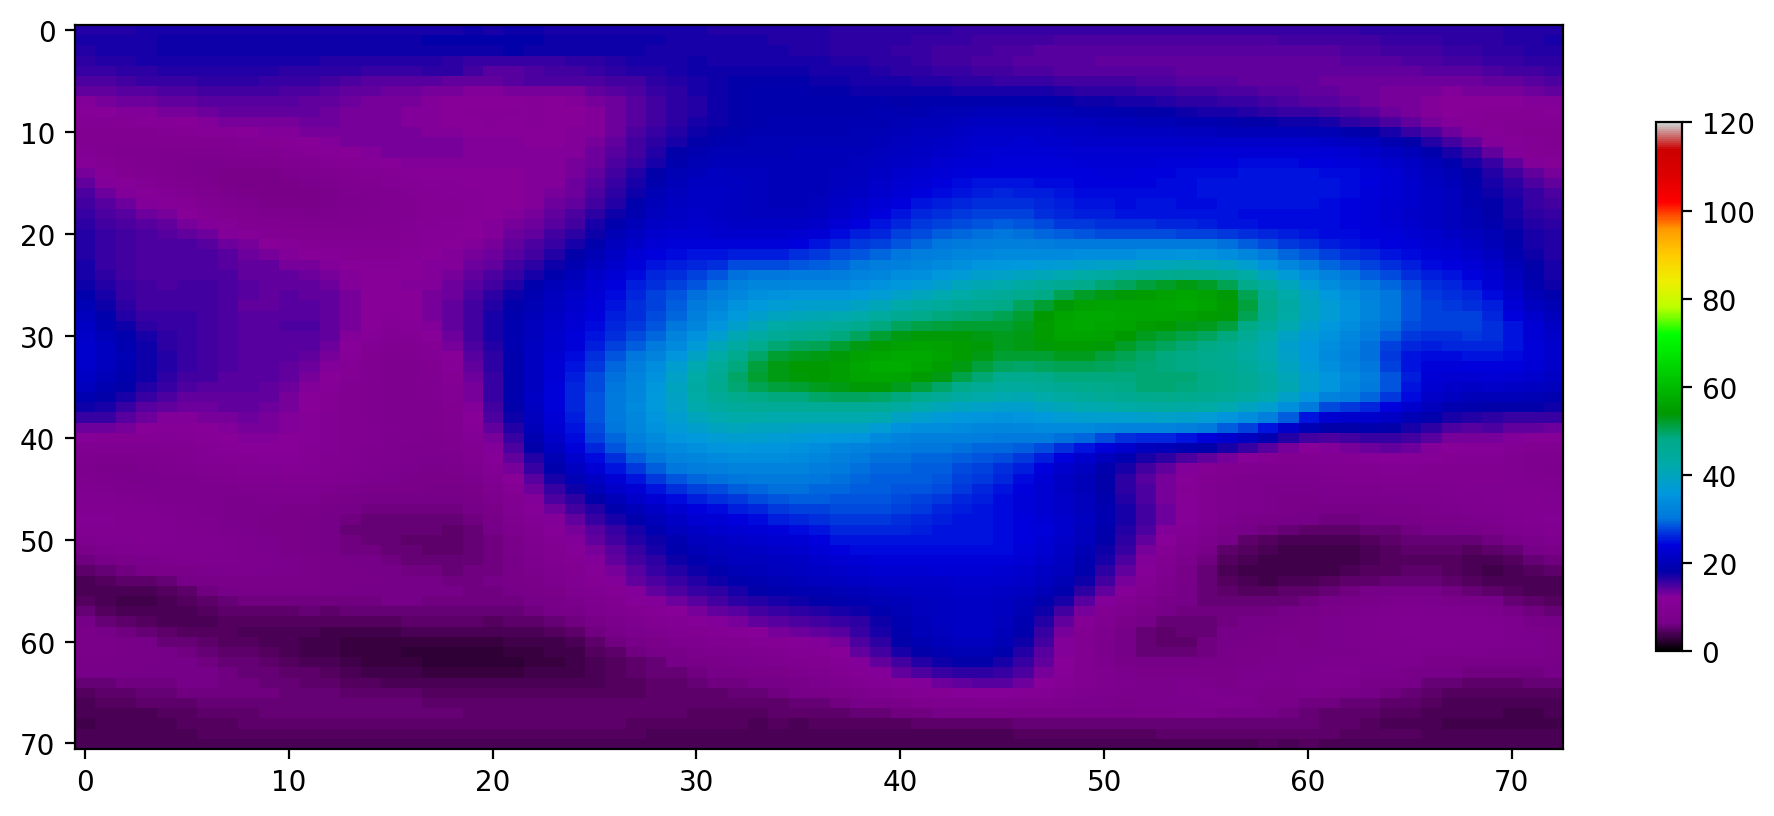

In [21]:
file20000715 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\load_data\\tec_2hr\\gps_tec2hr_igs_20030715_v01.h5"
bounds = np.linspace(0,100,5)

df = readH5File(file20000715)
print(df.columns)
df = df[pd.to_datetime(df.index.get_level_values('Epoch')) == '2003-07-15 12:00:00']['tecIGS']
df = df.unstack()
df = df.sort_index(axis=0, ascending=False)
df = df.sort_index(axis=1, ascending=True)
# print(df)
fig = plt.figure(figsize=(12, 7), dpi=200)
graph = plt.imshow(df, cmap= 'nipy_spectral', vmin = 0, vmax=120, aspect=0.5)
cb = plt.colorbar(graph, shrink = 0.5)
plt.show()

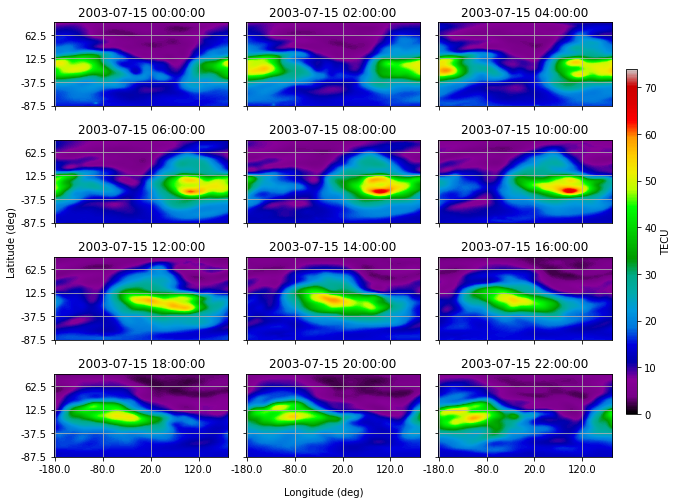

In [115]:
file20000715 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\load_data\\tec_2hr\\gps_tec2hr_igs_20030715_v01.h5"
date = '2003-07-15'
time = ['00:00:00', '02:00:00', '04:00:00', '06:00:00', '08:00:00', '10:00:00', '12:00:00', '14:00:00', '16:00:00', '18:00:00', '20:00:00', '22:00:00']
time = np.array_split(time,4)

df = readH5File(file20000715)
# print(df.max().max())
maxValue = df.max().max()

# print(df)
xindex = np.unique(df.index.get_level_values('lon'))
yindex = np.unique(df.index.get_level_values('lat'))
ytiks = range(0,71,20)
# yidx = np.linspace(0, len(yindex) - 1, 4).astype(int)
# print(yidx)


ylbl = yindex[ytiks]
xtiks = range(0,74,20)
xlbl = xindex[xtiks]

fig, axs = plt.subplots(len(time), len(time[0]),sharex=True, sharey=True, gridspec_kw={'hspace': 0.4, 'wspace': 0.1})
fig.set_figheight(8)
fig.set_figwidth(10)

for i in np.arange(len(time)):
    t = time[i]
    for j in np.arange(len(t)):
        tt = t[j]
        data = df[pd.to_datetime(df.index.get_level_values('Epoch')) == '{} {}'.format(date, tt)]['tecIGS']
        data = data.unstack()
        data = data.sort_index(axis=0, ascending=False)
        data = data.sort_index(axis=1, ascending=True)
        
        img = axs[i, j].imshow(data, interpolation='gaussian', aspect='auto', cmap='nipy_spectral', vmin=0, vmax=maxValue)
        axs[i, j].set_title('{} {}'.format(date, tt))
        axs[i, j].invert_yaxis()
        
        axs[i, j].set_yticks(ytiks) 
        axs[i, j].set_yticklabels(ylbl)
        
        axs[i, j].set_xticks(xtiks) 
        axs[i, j].set_xticklabels(xlbl)
        axs[i, j].grid()
#         axs[i, j].set_ylim(ymin=0, ymax=23)

cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
cbar = fig.colorbar(img, cax=cbar_ax, label='TECU')


fig.text(0.5, 0.06, 'Longitude (deg)', ha='center')
fig.text(0.06, 0.5, 'Latitude (deg)', va='center', rotation='vertical')


# df = df[pd.to_datetime(df.index.get_level_values('Epoch')) == '2003-07-15 12:00:00']['tecIGS']
# df = df.unstack()
# df = df.sort_index(axis=0, ascending=False)
# df = df.sort_index(axis=1, ascending=True)
# # print(df)
# fig = plt.figure(figsize=(12, 7), dpi=200)
# graph = plt.imshow(df, cmap= 'nipy_spectral', vmin = 0, vmax=120, aspect=0.5)
# cb = plt.colorbar(graph, shrink = 0.5)
fig.savefig(final_plot_location + 'igs_tec_map' + '.jpg', bbox_inches='tight', dpi= 200)
plt.show()

In [ ]:
from matplotlib import animation
file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og\\2000.h5"
bounds = np.linspace(0,100,5)
df = readH5File(file)
for i in df.index:
    data = df.loc[i]
    data = data.unstack()
    data = data.sort_index(axis=0, ascending=False)
    data = data.sort_index(axis=1, ascending=True)
    fig = plt.figure(figsize=(12, 7), dpi=200)
    graph = plt.imshow(data, cmap= 'nipy_spectral', vmin = 0, vmax=120, aspect=0.5)
    cb = plt.colorbar(graph, shrink = 0.5)
    plt.show()
    print(data)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython import display



def create_video(n):
    global X
    global df
    global index
    
    file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\tec\\2000.h5"
    bounds = np.linspace(0,100,5)
    df = readH5File(file)
#     print(df)
    index = df.index
    data = df.loc[index[0]]
    data = data.unstack()
    data = data.sort_index(axis=0, ascending=False)
    data = data.sort_index(axis=1, ascending=True)
    X = data
#     print(X)

    fig = plt.figure(figsize=(12, 7), dpi=200)
    im = plt.imshow(data, cmap= 'nipy_spectral', vmin = 0, vmax=120, aspect=0.5)
    plt.title(index[0])
    cb = plt.colorbar(im, shrink = 0.5)

    def animate(t):
        global X
        global index
        index = np.roll(index, -1, axis = 0)
        data = df.loc[index[0]]
        data = data.unstack()
        data = data.sort_index(axis=0, ascending=False)
        data = data.sort_index(axis=1, ascending=True)
        X = data
        im.set_array(X)
        plt.title(index[0])
        return im, 

    anim = FuncAnimation(
        fig,
        animate,
        frames = 100,
        interval = 1000/12,
        blit = True
    )

    plt.show()

    return anim

anim = create_video(10)
# writervideo = animation.FFMpegWriter(fps=60)
# anim.save("C:\\Users\\davi_fr\\Pictures\\Camera Roll\\anim.mp4", writer=writervideo)
# plt.close()

f = "C:\\Users\\davi_fr\\Pictures\\Camera Roll\\anim.mp4" 
writervideo = animation.FFMpegWriter(fps=60) 
anim.save(f, writer=writervideo)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython import display



def create_video(n):
    global X
    global df
    global index
    
    file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\append\\tec\\tec.h5"
    bounds = np.linspace(0,100,5)
    df = readH5File(file)
    print(df)
    index = df.index
    data = df.loc[index[0]]
#     data = data.unstack()
    data = data.sort_index(axis=0, ascending=False)
#     data = data.sort_index(axis=1, ascending=True)
    X = data
#     print(X)

    fig = plt.figure(figsize=(12, 7), dpi=200)
    im = plt.imshow(data, cmap= 'nipy_spectral', vmin = 0, vmax=120, aspect=0.5)
    plt.title(index[0])
    cb = plt.colorbar(im, shrink = 0.5)

    def animate(t):
        global X
        global index
        index = np.roll(index, -1, axis = 0)
        data = df.loc[index[0]]
#         data = data.unstack()
        data = data.sort_index(axis=0, ascending=False)
#         data = data.sort_index(axis=1, ascending=True)
        X = data
        im.set_array(X)
        plt.title(index[0])
        return im, 

    anim = FuncAnimation(
        fig,
        animate,
        frames = 100,
        interval = 1000/12,
        blit = True
    )

    plt.show()

    return anim

anim = create_video(10)
# writervideo = animation.FFMpegWriter(fps=60)
# anim.save("C:\\Users\\davi_fr\\Pictures\\Camera Roll\\anim.mp4", writer=writervideo)
# plt.close()

# f = "C:\\Users\\davi_fr\\Pictures\\Camera Roll\\anim.mp4" 
# writervideo = animation.FFMpegWriter(fps=60) 
# anim.save(f, writer=writervideo)

In [ ]:

sws_f10_corr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\correlation\\f10_7_sws\\f10_7_sws.h5"
sws_f10_corr_og_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\correlation\\f10_7_sws_og\\f10_7_sws_og.h5"


f10_7_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\f10_7\\f10_7.h5"
sws_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\solar_wind_speed\\solar_wind_speed.h5"



f10_7 = readH5File(f10_7_file)
sws = readH5File(sws_file)

crossCorr = f10_7['f10_7'].rolling(90).corr(sws['sws'])






corr_sws_f10_7_og = readH5File(sws_f10_corr_og_file)
ax = corr_sws_f10_7_og.plot(figsize=(15,5))
ax.grid('on', which='minor')
ax.grid('off', which='major')
ax.set_ylim(-0.7,0.7)
plt.title('Correlation F10.7 Radio Flux X Solar Wind Speed')
plt.xlabel('Date')
plt.ylabel('Correlation Coefficient')
plt.savefig('Correlation F10.7 Radio Flux X Solar Wind Speed.png', dpi=300)
plt.show()








In [ ]:
import seaborn as scb
# print(sws['sws'])
scb.distplot(f10_7['f10_7'])
plt.show()
scb.distplot(sws['sws'])
plt.show()

In [ ]:

tec_f10_7_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\correlation\\tec_f10_7_location_60_0\\tec_f10_7_location_60_0.h5"
tec_f10_7_norm_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\normalised_correlation\\tec_f10_7_location_60_0\\tec_f10_7_location_60_0.h5"
tec_f10_7_corrr_lowerLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_f10_7_location_60_0\\conf_int_corr_tec_f10_7_location_60_0_lowerConfInterval.h5"
tec_f10_7_corrr_upperLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_f10_7_location_60_0\\conf_int_corr_tec_f10_7_location_60_0_upperConfInterval.h5"

tec_f10_7_corrr = readH5File(tec_f10_7_corrr_file)
tec_f10_7_norm_corrr = readH5File(tec_f10_7_norm_corrr_file)
tec_f10_7_corrr_lowerLimit = readH5File(tec_f10_7_corrr_lowerLimitFile)
tec_f10_7_corrr_upperLimit = readH5File(tec_f10_7_corrr_upperLimitFile)

fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('Correlation F10.7 radio Flux X Total Electron Content at 60N 0E')
fig.set_size_inches(15, 8)
axs[0].xaxis.set_tick_params(which='both', labelbottom=True)

axs[0].plot(f10_7, label='F10.7 Radio Flux')
axs[0].grid('on', which='minor')
axs[0].grid('off', which='major')
axs[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axs[1].plot(tec_f10_7_corrr, label='Correlation F10.7 X TEC (Box Window)')
axs[1].plot(tec_f10_7_norm_corrr, label='Correlation F10.7 X TEC (Gaussian Window)')
# axs[1].plot(tec_f10_7_corrr)
# axs[1].plot(tec_f10_7_corrr)

axs[1].grid('on', which='minor')
axs[1].grid('off', which='major')
axs[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs[1].set_ylim(-1,1)

xAxis = tec_f10_7_corrr_lowerLimit.index
                
yAxisLower = tec_f10_7_corrr_lowerLimit[(60,0)]
yAxisUpper = tec_f10_7_corrr_upperLimit[(60,0)]
axs[1].fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.5, linewidth=0, color='gray', label='95% confidence interval')


axs[1].set_xlabel('Date')
axs[1].set_ylabel('Correlation Coefficient')
axs[0].set_ylabel('10.7cm Radio Flux (sfu)')

axs[1].legend()
axs[0].legend()       
plt.savefig('Correlation F10.7 radio Flux X Total Electron Content at 60N 0E.png', dpi=300)
plt.show()


In [ ]:





tec_sws_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\correlation\\tec_sws_location_60_0\\tec_sws_location_60_0.h5"
tec_sws_norm_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\normalised_correlation\\tec_sws_location_60_0\\tec_sws_location_60_0.h5"
tec_sws_corrr_lowerLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_sws_location_60_0\\conf_int_corr_tec_sws_location_60_0_lowerConfInterval.h5"
tec_sws_corrr_upperLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_sws_location_60_0\\conf_int_corr_tec_sws_location_60_0_upperConfInterval.h5"

tec_sws_corrr = readH5File(tec_sws_corrr_file)
tec_sws_norm_corrr = readH5File(tec_sws_norm_corrr_file)
tec_sws_corrr_lowerLimit = readH5File(tec_sws_corrr_lowerLimitFile)
tec_sws_corrr_upperLimit = readH5File(tec_sws_corrr_upperLimitFile)


fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('Correlation Solar Wind Speed X Total Electron Content at 60N 0E')
fig.set_size_inches(15, 8)

axs[0].plot(f10_7, label='F10.7 Radio Flux')
axs[0].grid('on', which='minor')
axs[0].grid('off', which='major')
axs[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axs[1].plot(tec_sws_corrr, label='Correlation Solar Wind Speed X TEC (Box Window)')
axs[1].plot(tec_sws_norm_corrr, label='Correlation Solar Wind Speed X TEC (Gaussian Window)')


axs[1].grid('on', which='minor')
axs[1].grid('off', which='major')
axs[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs[1].set_ylim(-1,1)

xAxis = tec_sws_corrr_lowerLimit.index
                
yAxisLower = tec_sws_corrr_lowerLimit[(60,0)]
yAxisUpper = tec_sws_corrr_upperLimit[(60,0)]
axs[1].fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.5, linewidth=0, color='gray', label='95% confidence interval')

axs[1].set_xlabel('Date')
axs[1].set_ylabel('Correlation Coefficient')
axs[0].set_ylabel('10.7cm Radio Flux (sfu)')


axs[1].legend()
axs[0].legend()   
plt.savefig('Correlation Solar Wind Speed X Total Electron Content at 60N 0E.png', dpi=300)
plt.show()

In [ ]:
tec_sws_2002_2008 = tec_sws_corrr[(tec_sws_corrr.index.get_level_values('date') >= pd.to_datetime('01-01-2002').date()) & 
                                  (tec_sws_corrr.index.get_level_values('date') <= pd.to_datetime('31-12-2008').date())]

tec_f10_2002_2008 = tec_f10_7_corrr[(tec_f10_7_corrr.index.get_level_values('date') >= pd.to_datetime('01-01-2002').date()) & 
                                  (tec_f10_7_corrr.index.get_level_values('date') <= pd.to_datetime('31-12-2008').date())]



fig, axs = plt.subplots(2, sharex=True)
# fig.suptitle('Correlation F10.7 radio Flux X Total Electron Content at 60N')
fig.set_size_inches(6, 4)

axs[0].plot(tec_f10_2002_2008, label='Corr F10.7 Radio Flux')
axs[0].grid('on', which='minor')
axs[0].grid('off', which='major')
# axs[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axs[1].plot(tec_sws_2002_2008, label='Correlation SWS X TEC')
# axs[1].plot(tec_f10_7_norm_corrr, label='Correlation F10.7 X TEC (Gaussian Window)')
# axs[1].plot(tec_f10_7_corrr)
# axs[1].plot(tec_f10_7_corrr)

axs[1].grid('on', which='minor')
axs[1].grid('off', which='major')
# axs[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs[1].set_ylim(-1,1)
axs[0].set_ylim(-1,1)
axs[1].yaxis.set_minor_locator(AutoMinorLocator(2))
axs[0].yaxis.set_minor_locator(AutoMinorLocator(2))
# xAxis = tec_f10_7_corrr_lowerLimit.index
                
# yAxisLower = tec_f10_7_corrr_lowerLimit[(60,0)]
# yAxisUpper = tec_f10_7_corrr_upperLimit[(60,0)]
# axs[1].fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.5, linewidth=0, color='gray', label='95% confidence interval')


axs[1].set_xlabel('Date')
axs[1].set_ylabel('Correlation Coefficient')
# axs[0].set_ylabel('10.7cm Radio Flux (sfu)')

axs[1].legend()
axs[0].legend()       
plt.savefig('Correlation at 60N 2002 2008.png', dpi=300)
plt.show()





#Relative difference difference equation change

tec_f10_7_corrr_file_rel = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\correlation\\tec_f10_7_location_60_0\\tec_f10_7_location_60_0.h5"
tec_f10_7_norm_corrr_file_rel = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\normalised_correlation\\tec_f10_7_location_60_0\\tec_f10_7_location_60_0.h5"
# tec_f10_7_corrr_lowerLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\confidence_interval\\conf_int_corr_tec_f10_7_location_60_0\\conf_int_corr_tec_f10_7_location_60_0_lowerConfInterval.h5"
# tec_f10_7_corrr_upperLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\confidence_interval\\conf_int_corr_tec_f10_7_location_60_0\\conf_int_corr_tec_f10_7_location_60_0_upperConfInterval.h5"

tec_f10_7_corrr_rel = readH5File(tec_f10_7_corrr_file_rel)
tec_f10_7_norm_corrr_rel = readH5File(tec_f10_7_norm_corrr_file_rel)
# tec_f10_7_corrr_lowerLimit = readH5File(tec_f10_7_corrr_lowerLimitFile)
# tec_f10_7_corrr_upperLimit = readH5File(tec_f10_7_corrr_upperLimitFile)



tec_sws_corrr_file_rel = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\correlation\\tec_sws_location_60_0\\tec_sws_location_60_0.h5"
tec_sws_norm_corrr_file_rel = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\normalised_correlation\\tec_sws_location_60_0\\tec_sws_location_60_0.h5"
# tec_sws_corrr_lowerLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\confidence_interval\\conf_int_corr_tec_sws_location_60_0\\conf_int_corr_tec_sws_location_60_0_lowerConfInterval.h5"
# tec_sws_corrr_upperLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\confidence_interval\\conf_int_corr_tec_sws_location_60_0\\conf_int_corr_tec_sws_location_60_0_upperConfInterval.h5"

tec_sws_corrr_rel = readH5File(tec_sws_corrr_file_rel)
tec_sws_norm_corrr_rel = readH5File(tec_sws_norm_corrr_file_rel)
# tec_sws_corrr_lowerLimit = readH5File(tec_sws_corrr_lowerLimitFile)
# tec_sws_corrr_upperLimit = readH5File(tec_sws_corrr_upperLimitFile)


tec_sws_2002_2008 = tec_sws_corrr_rel[(tec_sws_corrr_rel.index.get_level_values('date') >= pd.to_datetime('01-01-2002').date()) & 
                                  (tec_sws_corrr_rel.index.get_level_values('date') <= pd.to_datetime('31-12-2008').date())]

tec_f10_2002_2008 = tec_f10_7_corrr_rel[(tec_f10_7_corrr_rel.index.get_level_values('date') >= pd.to_datetime('01-01-2002').date()) & 
                                  (tec_f10_7_corrr_rel.index.get_level_values('date') <= pd.to_datetime('31-12-2008').date())]



fig, axs = plt.subplots(2, sharex=True)
# fig.suptitle('Correlation F10.7 radio Flux X Total Electron Content at 60N')
fig.set_size_inches(6, 4)

axs[0].plot(tec_f10_2002_2008, label='Corr F10.7 Radio Flux')
axs[0].grid('on', which='minor')
axs[0].grid('off', which='major')
# axs[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axs[1].plot(tec_sws_2002_2008, label='Correlation SWS X TEC')
# axs[1].plot(tec_f10_7_norm_corrr, label='Correlation F10.7 X TEC (Gaussian Window)')
# axs[1].plot(tec_f10_7_corrr)
# axs[1].plot(tec_f10_7_corrr)

axs[1].grid('on', which='minor')
axs[1].grid('off', which='major')
# axs[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs[1].set_ylim(-1,1)
axs[0].set_ylim(-1,1)
axs[1].yaxis.set_minor_locator(AutoMinorLocator(2))
axs[0].yaxis.set_minor_locator(AutoMinorLocator(2))
# xAxis = tec_f10_7_corrr_lowerLimit.index
                
# yAxisLower = tec_f10_7_corrr_lowerLimit[(60,0)]
# yAxisUpper = tec_f10_7_corrr_upperLimit[(60,0)]
# axs[1].fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.5, linewidth=0, color='gray', label='95% confidence interval')


axs[1].set_xlabel('Date')
axs[1].set_ylabel('Correlation Coefficient')
# axs[0].set_ylabel('10.7cm Radio Flux (sfu)')

axs[1].legend()
axs[0].legend()       
plt.savefig('Correlation at 60N 2002 2008_rel.png', dpi=300)
plt.show()

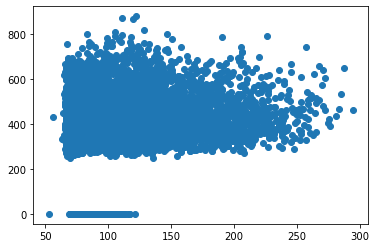

In [210]:
f10_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\f10_7\\f10_7.h5"
sws_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\solar_wind_speed\\solar_wind_speed.h5"

f10 = readH5File(f10_file)
sws = readH5File(sws_file)

f10 = f10.fillna(0)
sws = sws.fillna(0)
# print(f10)
# print(sws)
# m, b = np.polyfit(f10['f10_7'], sws['sws'], 1)
plt.scatter(f10['f10_7'], sws['sws'])

# plt.plot(f10['f10_7'], m*f10['f10_7']+b, color="red")
# plt.plot(sws['sws'], m*sws['sws']+b, color="yellow")
plt.show()


In [ ]:
tec = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\append\\tec\\tec.h5"
sws = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\sws\\sws.h5"
f10 = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\f10_7\\f10_7.h5"

tecData = readH5File(tec)
f10Data = readH5File(f10)
swsData = readH5File(sws)

tecData = tecData.fillna(0)
f10Data = f10Data.fillna(0)
swsData = swsData.fillna(0)

plt.scatter(tecData[55], swsData['sws'])

m, b = np.polyfit(tecData[55], swsData['sws'], 1)
plt.plot(tecData[55], m*tecData[55]+b, color="red")

plt.show()



plt.scatter(tecData[55], f10Data['f10_7'])

m, b = np.polyfit(tecData[55], f10Data['f10_7'], 1)
plt.plot(tecData[55], m*tecData[55]+b, color="red")

plt.show()
plt.scatter(swsData['sws'], f10Data['f10_7'])

m, b = np.polyfit(swsData['sws'], f10Data['f10_7'], 1)
plt.plot(swsData['sws'], m*swsData['sws']+b, color="red")


NameError: name 'f10_7' is not defined

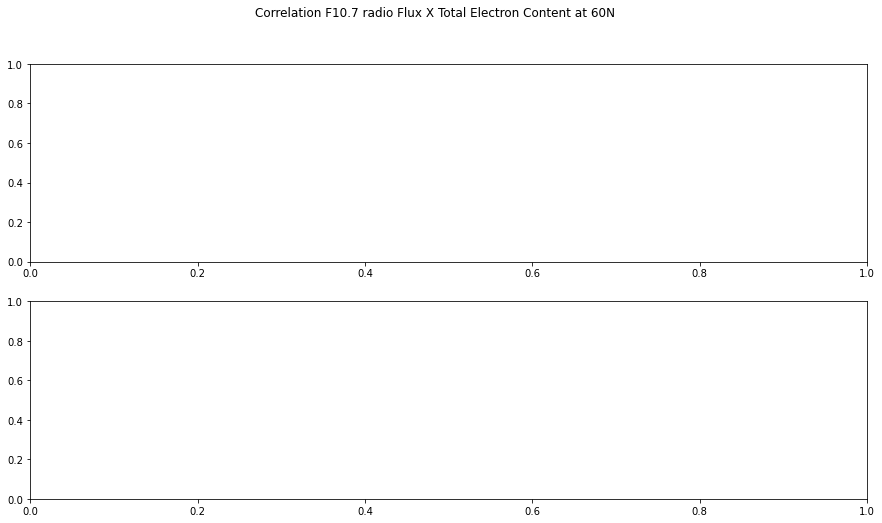

In [211]:
tec_f10_7_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\correlation\\tec_f10_7\\tec_f10_7.h5"
tec_f10_7_norm_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\normalised_correlation\\tec_f10_7\\tec_f10_7.h5"
tec_f10_7_corrr_lowerLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_f10_7\\conf_int_corr_tec_f10_7_lowerConfInterval.h5"
tec_f10_7_corrr_upperLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_f10_7\\conf_int_corr_tec_f10_7_upperConfInterval.h5"

tec_f10_7_corrr = readH5File(tec_f10_7_corrr_file)
tec_f10_7_norm_corrr = readH5File(tec_f10_7_norm_corrr_file)
tec_f10_7_corrr_lowerLimit = readH5File(tec_f10_7_corrr_lowerLimitFile)
tec_f10_7_corrr_upperLimit = readH5File(tec_f10_7_corrr_upperLimitFile)



tec_f10_7_corrr = tec_f10_7_corrr[[60.0]]
tec_f10_7_norm_corrr = tec_f10_7_norm_corrr[60.0]
tec_f10_7_corrr_lowerLimit = tec_f10_7_corrr_lowerLimit[60.0]
tec_f10_7_corrr_upperLimit = tec_f10_7_corrr_upperLimit[60.0]


# print(tec_f10_7_corrr_lowerLimit)

fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('Correlation F10.7 radio Flux X Total Electron Content at 60N')
fig.set_size_inches(15, 8)
axs[0].xaxis.set_tick_params(which='both', labelbottom=True)
axs[0].plot(f10_7, label='F10.7 Radio Flux')
axs[0].grid('on', which='minor')
axs[0].grid('off', which='major')
axs[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axs[1].plot(tec_f10_7_corrr, label='Correlation F10.7 X TEC (Box Window)')
axs[1].plot(tec_f10_7_norm_corrr, label='Correlation F10.7 X TEC (Gaussian Window)')
# axs[1].plot(tec_f10_7_corrr)
# axs[1].plot(tec_f10_7_corrr)

axs[1].grid('on', which='minor')
axs[1].grid('off', which='major')
axs[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs[1].set_ylim(-1,1)

xAxis = tec_f10_7_corrr_lowerLimit.index
                
yAxisLower = tec_f10_7_corrr_lowerLimit
yAxisUpper = tec_f10_7_corrr_upperLimit
axs[1].fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.5, linewidth=0, color='gray', label='95% confidence interval')


axs[1].set_xlabel('Date')
axs[1].set_ylabel('Correlation Coefficient')
axs[0].set_ylabel('10.7cm Radio Flux (sfu)')

axs[1].legend()
axs[0].legend()       
plt.savefig('Correlation F10.7 radio Flux X Total Electron Content at 60N.png', dpi=300)
plt.show()



# pd.set_option("display.max_rows", None, "display.max_columns", None)
# temp = f10_7.sort_values('f10_7', ascending=False).head(200)

# temp1 = temp.sort_index()
# print(temp1)

In [ ]:
# print(tec_f10_7_corrr)
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
# Use the Autocorrelation function
# from the statsmodel library passing
# our DataFrame object in as the data
# Note: Limiting Lags to 50
plot_acf(tec_f10_7_corrr, lags=27*12*11, missing='drop')
# Show the AR as a plot
plt.show()
plot_acf(tec_sws_corrr, lags=27*12, missing='drop')
plt.show()

NameError: name 'f10_7' is not defined

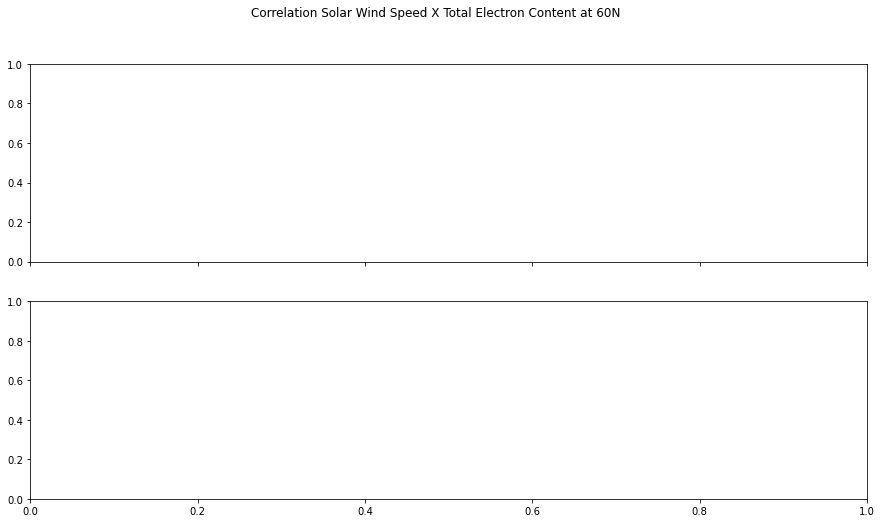

In [209]:


tec_sws_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\correlation\\tec_sws\\tec_sws.h5"
tec_sws_norm_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\normalised_correlation\\tec_sws\\tec_sws.h5"
tec_sws_corrr_lowerLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_sws\\conf_int_corr_tec_sws_lowerConfInterval.h5"
tec_sws_corrr_upperLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_test_270622\\computations\\confidence_interval\\conf_int_corr_tec_sws\\conf_int_corr_tec_sws_upperConfInterval.h5"

tec_sws_corrr = readH5File(tec_sws_corrr_file)
tec_sws_norm_corrr = readH5File(tec_sws_norm_corrr_file)
tec_sws_corrr_lowerLimit = readH5File(tec_sws_corrr_lowerLimitFile)
tec_sws_corrr_upperLimit = readH5File(tec_sws_corrr_upperLimitFile)


tec_sws_corrr = tec_sws_corrr[60.0]
tec_sws_norm_corrr = tec_sws_norm_corrr[60.0]
tec_sws_corrr_lowerLimit = tec_sws_corrr_lowerLimit[60.0]
tec_sws_corrr_upperLimit = tec_sws_corrr_upperLimit[60.0]

fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('Correlation Solar Wind Speed X Total Electron Content at 60N')
fig.set_size_inches(15, 8)

axs[0].plot(f10_7, label='F10.7 Radio Flux')
axs[0].grid('on', which='minor')
axs[0].grid('off', which='major')
axs[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axs[1].plot(tec_sws_corrr, label='Correlation Solar Wind Speed X TEC (Box Window)')
axs[1].plot(tec_sws_norm_corrr, label='Correlation Solar Wind Speed X TEC (Gaussian Window)')


axs[1].grid('on', which='minor')
axs[1].grid('off', which='major')
axs[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs[1].set_ylim(-1,1)

xAxis = tec_sws_corrr_lowerLimit.index
                
yAxisLower = tec_sws_corrr_lowerLimit
yAxisUpper = tec_sws_corrr_upperLimit
axs[1].fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.5, linewidth=0, color='gray', label='95% confidence interval')

axs[1].set_xlabel('Date')
axs[1].set_ylabel('Correlation Coefficient')
axs[0].set_ylabel('10.7cm Radio Flux (sfu)')


axs[1].legend()
axs[0].legend()   
plt.savefig('Correlation Solar Wind Speed X Total Electron Content at 60N.png', dpi=300)
plt.show()

window_size
1.0            NaN
2.0      -0.028481
3.0      -0.053430
4.0      -0.079770
5.0      -0.099375
            ...   
8761.0         NaN
8762.0         NaN
8763.0         NaN
8764.0         NaN
8765.0         NaN
Name: (52.5, correlation_sws_rel_diff), Length: 8765, dtype: float64
-0.21020985122560065


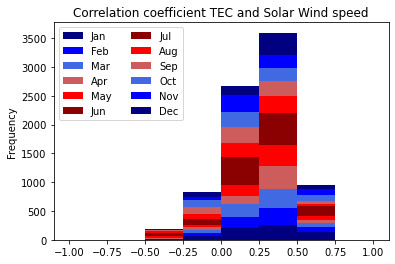

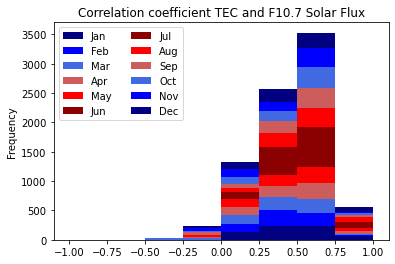

In [207]:
meanCorrelation = readH5File('mean_correlation_latitude_all_window_size.h5')
meanCorrelationsws = meanCorrelation[(52.5,'correlation_sws_rel_diff')]
meanCorrealtionsws = meanCorrelationsws.loc[90]
print(meanCorrelation[(52.5,'correlation_sws_rel_diff')])
print(meanCorrealtionsws)
colors = plt.cm.rainbow(np.linspace(0, 1, 12))

colors = ['navy', 'blue','royalblue','indianred','red','darkred','darkred','red','indianred','royalblue', 'blue','navy']
binSize = np.arange(-1, 1, 0.1)
# print(tec_sws_corrr)
tec_sws_corrr_datesplit = tec_sws_corrr.copy().to_frame()
# tec_sws_corrr_datesplit = tec_sws_corrr_datesplit - meanCorrealtionsws
tec_sws_corrr_datesplit.index = pd.to_datetime(tec_sws_corrr_datesplit.index, format='%Y-%m-%d')
# print(tec_sws_corrr_datesplit)
tec_sws_corrr_datesplit['day'] = tec_sws_corrr_datesplit.index.day
# print(tec_sws_corrr_datesplit)
tec_sws_corrr_datesplit['month'] = tec_sws_corrr_datesplit.index.month
tec_sws_corrr_datesplit['year'] = tec_sws_corrr_datesplit.index.year
tec_sws_corrr_datesplit = tec_sws_corrr_datesplit.reset_index().drop('date', axis=1).set_index(['day', 'month', 'year']).unstack('month')

# plt.hist(tec_sws_corrr_datesplit, bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], stacked = True)
tec_sws_corrr_datesplit.plot.hist(bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], stacked = True, color=colors)
# tec_sws_corrr_datesplit.plot.hist(bins=binSize, stacked = True, color=colors)
plt.legend(['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ncol=2)
plt.title('Correlation coefficient TEC and Solar Wind speed')
plt.show()



# print(tec_sws_corrr)
tec_f10_7_corrr_datesplit = tec_f10_7_corrr.copy()
tec_f10_7_corrr_datesplit.index = pd.to_datetime(tec_f10_7_corrr_datesplit.index, format='%Y-%m-%d')
# print(tec_sws_corrr_datesplit)
tec_f10_7_corrr_datesplit['day'] = tec_f10_7_corrr_datesplit.index.day
# print(tec_sws_corrr_datesplit)
tec_f10_7_corrr_datesplit['month'] = tec_f10_7_corrr_datesplit.index.month
tec_f10_7_corrr_datesplit['year'] = tec_f10_7_corrr_datesplit.index.year
tec_f10_7_corrr_datesplit = tec_f10_7_corrr_datesplit.reset_index().drop('date', axis=1).set_index(['day', 'month', 'year']).unstack('month')

# print(tec_f10_7_corrr_datesplit)


# plt.hist(tec_f10_7_corrr_datesplit, bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], stacked = True, color = colors)

tec_f10_7_corrr_datesplit.plot.hist(bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], stacked = True, color=colors)
# tec_f10_7_corrr_datesplit.plot.hist(bins=binSize, stacked = True, color=colors)
plt.legend(['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ncol=2)
plt.title('Correlation coefficient TEC and F10.7 Solar Flux')
plt.show()

# FINAL PLOTS

### Total Electron Content

In [102]:
tec_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og"
tec_data_og = pd.DataFrame()
for year in analysisPeriod:
    tec_file_path = tec_file + "\\" + str(year) + ".h5"
    tecData = readH5File(tec_file_path)
    tecData = tecData[[60, 30, 0]]
    tecData = tecData.mean(level=0)
#     print(tecData.mean(level=0))
    tec_data_og = tec_data_og.append(tecData)

C:\Users\davi_fr\AppData\Local\Temp/ipykernel_15460/237717457.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  tecData = tecData.mean(level=0)


In [112]:
display(tec_data_og)

lat             60.0                                                    \
lon             -180      -175      -170      -165      -160      -155   
date                                                                     
1997-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1997-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2020-12-27  4.000000  3.883333  3.875000  3.925000  3.812500  3.787500   
2020-12-28  4.929167  4.750000  4.704167  4.679167  4.450000  4.320833   
2020-12-29  4.508333  4.383333  4.329167  4.229167  3.970833  3.820833   
2020-12-30  4.116667  3.987500  3.920833  3.841667  3.737500  3.687500   
2020-12-31  3.495833  3.491667  3.537500  3.450000  3.433333  3.379167   

lat                                                 ...       0.0              \
lon             -150      -145      -140      -135  ...        135        140   
date                                                ...                         
1997-01-01       NaN       NaN       NaN       NaN  ...        NaN        NaN   
1997-01-02       NaN       NaN       NaN       NaN  ...        NaN        NaN   
1997-01-03       NaN       NaN       NaN       NaN  ...        NaN        NaN   
1997-01-04       NaN       NaN       NaN       NaN  ...        NaN        NaN   
1997-01-05       NaN       NaN       NaN       NaN  ...        NaN        NaN   
...              ...       ...       ...       ...  ...        ...        ...   
2020-12-27  3.720833  3.566667  3.541667  3.537500  ...  18.020833  17.954167   
2020-12-28  4.225000  3.979167  3.887500  3.804167  ...  16.641667  16.591667   
2020-12-29  3.679167  3.479167  3.337500  3.304167  ...  15.850000  15.858333   
2020-12-30  3.595833  3.516667  3.425000  3.404167  ...  15.408333  15.604167   
2020-12-31  3.266667  3.145833  3.004167  2.941667  ...  14.100000  14.270833   

lat                                                                           \
lon               145        150        155        160        165        170   
date                                                                           
1997-01-01        NaN        NaN        NaN        NaN        NaN        NaN   
1997-01-02        NaN        NaN        NaN        NaN        NaN        NaN   
1997-01-03        NaN        NaN        NaN        NaN        NaN        NaN   
1997-01-04        NaN        NaN        NaN        NaN        NaN        NaN   
1997-01-05        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2020-12-27  17.787500  17.808333  18.000000  17.891667  17.825000  17.529167   
2020-12-28  16.620833  17.212500  17.520833  18.179167  18.470833  17.991667   
2020-12-29  16.058333  16.362500  16.958333  17.400000  17.562500  17.345833   
2020-12-30  15.845833  16.645833  17.691667  18.000000  18.087500  17.816667   
2020-12-31  14.383333  15.391667  15.979167  16.037500  16.087500  15.887500   

lat                               
lon               175        180  
date                              
1997-01-01        NaN        NaN  
1997-01-02        NaN        NaN  
1997-01-03        NaN        NaN  
1997-01-04        NaN        NaN  
1997-01-05        NaN        NaN  
...               ...        ...  
2020-12-27  17.337500  17.020833  
2020-12-28  17.800000  17.516667  
2020-12-29  17.162500  16.983333  
2020-12-30  17.629167  17.100000  
2020-12-31  15.675000  15.325000  

[8766 rows x 219 columns]

lat              0.0       30.0      60.0
date                                     
1997-01-01        NaN       NaN       NaN
1997-01-02        NaN       NaN       NaN
1997-01-03        NaN       NaN       NaN
1997-01-04        NaN       NaN       NaN
1997-01-05        NaN       NaN       NaN
...               ...       ...       ...
2020-12-27  17.753824  8.652626  4.109874
2020-12-28  17.994749  8.977968  4.511929
2020-12-29  17.226941  8.602340  4.062329
2020-12-30  18.532363  8.992523  4.123630
2020-12-31  16.986358  8.526142  3.734132

[8766 rows x 3 columns]


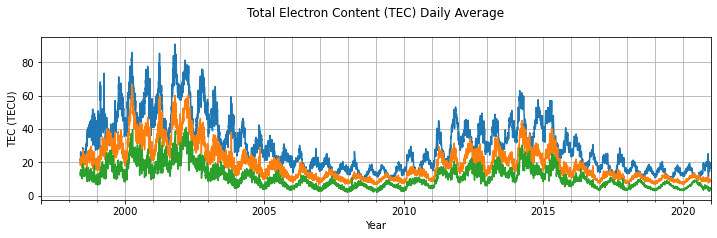

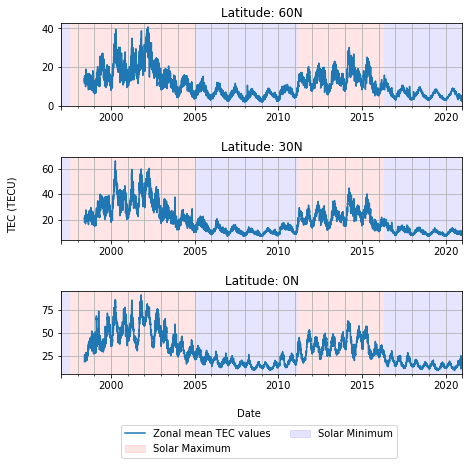

In [103]:
# tec_data_og['moving_avg'] = tec_data_og[(52.5, 15)].rolling(27).mean()
# tec_data_og['moving_avg'] = tec_data_og['moving_avg'].interpolate()

tec_data_og = tec_data_og.groupby(level = 'lat', axis = 1).mean()
print(tec_data_og)
tec_data_og.index = pd.to_datetime(tec_data_og.index)
ax = tec_data_og.plot(figsize=(12, 3), legend=None)
# ax.xaxis.set_major_locator(plt.MaxNLocator(12))
ax.set_xlabel("Year")
ax.set_ylabel("TEC (TECU)")
# xticklabels = ax.get_xticklabels()

# tec_ma.plot(figsize=(8, 3), legend=None)
ax.grid('on', which='minor', axis='x' )
ax.grid('off', which='major', axis='x' )
ax.grid('on', which='minor', axis='y' )
ax.grid('off', which='major', axis='y' )
plt.title('Total Electron Content (TEC) Daily Average', pad=20)
plt.savefig(final_plot_location + 'tec.png', dpi=150, bbox_inches = "tight")
plt.show()




lat = [60, 30 ,0]


fig, axs = plt.subplots(len(lat))
fig.set_figheight(6)
fig.set_figwidth(8)
fig.tight_layout(pad=3.0)


for j in np.arange(len(lat)):
    plotlat = lat[j]
    
    
    data_lat = tec_data_og[(plotlat)]
    data_lat.plot(ax=axs[j])
    
    
    axs[j].grid('on', which='minor', axis='x' )
    axs[j].grid('off', which='major', axis='x' )
    axs[j].grid('on', which='minor', axis='y' )
    axs[j].grid('off', which='major', axis='y' )



    axs[j].set_title('Latitude: {}N'.format(plotlat))
    axs[j].set_xlabel("")
    
    axs[j].axvspan('1997-01-01', '1997-07-18', facecolor='blue', alpha=0.1)
    axs[j].axvspan('1997-07-18', '2005-01-20', facecolor='red', alpha=0.1)
    axs[j].axvspan('2005-01-20', '2011-03-13', facecolor='blue', alpha=0.1)
    axs[j].axvspan('2011-03-13', '2016-04-23', facecolor='red', alpha=0.1)
    axs[j].axvspan('2016-04-23 ', '2020-12-31', facecolor='blue', alpha=0.1)

fig.subplots_adjust(right=0.8)

fig.text(0.43, 0.01, 'Date', ha='center')
fig.text(0.01, 0.5, 'TEC (TECU)', va='center', rotation='vertical')
# plt.title('Total Electron Content (TEC) Daily Average', pad=20)

red_line = Line2D([0], [0], color='tab:blue', label='Zonal mean TEC values')
# green_line = Line2D([0], [0], color='tab:orange', label='F10.7 solar flux 3 year moving average')
# gray_patch = mpatches.Patch(color='gray', alpha=0.7, label='95% confidence interval')
red_patch = mpatches.Patch(color='red', alpha=0.1, label='Solar Maximum')
blue_patch = mpatches.Patch(color='blue', alpha=0.1, label='Solar Minimum')
lg = plt.legend(handles=[red_line, red_patch, blue_patch], ncol=2, bbox_to_anchor=(0.85, -0.55))


plt.savefig(final_plot_location +'tec_lat_0_30_60.pdf',dpi=300, bbox_inches = 'tight')


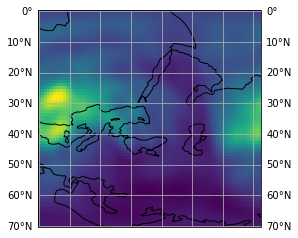

In [165]:
tec_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\tec_og\\2003.h5"
tecData_temp = readH5File(tec_file)

tecData_temp = tecData_temp
# extData = data[(data.index.get_level_values('date') >= startDate) & 
#                    (data.index.get_level_values('date') <= endDate)]

ext_ut_data = pd.DataFrame(tecData_temp.iloc[0])
ext_ut_data = ext_ut_data.unstack()

# print(ext_ut_data.columns)

ax   = plt.axes(projection=ccrs.PlateCarree())

# plt.imshow(ext_ut_data, cmap = 'viridis', transform=ccrs.PlateCarree())
plt.contourf(lons, lats, prc, cmap = 'YlOrRd', transform=ccrs.PlateCarree())

# ax.set_extent([30, 170, -30, 30])   # regional map (x0, x1, y0, y1)  
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.show()

### F10.7 Solar Flux

f10_7    66.6
Name: 2018-11-27 00:00:00, dtype: float64


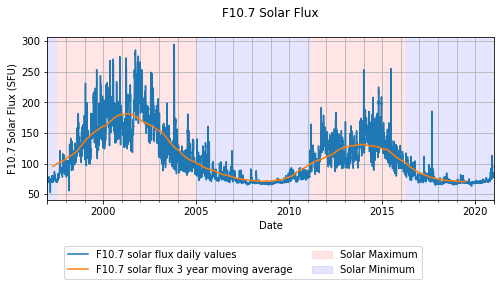

In [147]:
f10_7_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\f10_7\\f10_7.h5"
f10_7Data = readH5File(f10_7_file)
print(f10_7Data.iloc[8000])
windowSize = 3*365
f10_7Data['moving_avg'] = f10_7Data.rolling(window=windowSize, min_periods=int(windowSize*60/100)).mean()
f10_7Data['moving_avg'] = f10_7Data['moving_avg'].shift(int(windowSize/2)*-1)
ax = f10_7Data.plot(figsize=(8, 3), legend=None)
ax.set_xlabel("Date")
ax.set_ylabel("F10.7 Solar Flux (SFU)")
ax.grid('on', which='minor', axis='x' )
ax.grid('off', which='major', axis='x' )
ax.grid('on', which='minor', axis='y' )
ax.grid('off', which='major', axis='y' )


ax.axvspan('1997-01-01', '1997-07-18', facecolor='blue', alpha=0.1)
ax.axvspan('1997-07-18', '2005-01-20', facecolor='red', alpha=0.1)
ax.axvspan('2005-01-20', '2011-03-13', facecolor='blue', alpha=0.1)
ax.axvspan('2011-03-13', '2016-04-23', facecolor='red', alpha=0.1)
ax.axvspan('2016-04-23 ', '2020-12-31', facecolor='blue', alpha=0.1)


plt.title('F10.7 Solar Flux', pad=20)

ax.legend(framealpha=0.4)
red_line = Line2D([0], [0], color='tab:blue', label='F10.7 solar flux daily values')
green_line = Line2D([0], [0], color='tab:orange', label='F10.7 solar flux 3 year moving average')
# gray_patch = mpatches.Patch(color='gray', alpha=0.7, label='95% confidence interval')
red_patch = mpatches.Patch(color='red', alpha=0.1, label='Solar Maximum')
blue_patch = mpatches.Patch(color='blue', alpha=0.1, label='Solar Minimum')
lg = plt.legend(handles=[red_line, green_line, red_patch, blue_patch], ncol=2, bbox_to_anchor=(0.85, -0.25))



plt.savefig(final_plot_location + 'f10_7_smm.pdf', dpi=300, bbox_inches = "tight")
plt.show()

In [13]:
f10_7_file_ma = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\moving_average\\f10_7\\f10_7.h5"
f10_7Data_ma = readH5File(f10_7_file_ma)

print(f10_7Data_ma)
f10_7Data_ma.index =  pd.to_datetime(f10_7Data_ma.index, format='%Y-%m-%d')
print(f10_7Data_ma.index)
f10_7Data_2002_2008 = f10_7Data_ma[(f10_7Data_ma.index.get_level_values('date') >= '01-01-2009') & 
                                  (f10_7Data_ma.index.get_level_values('date') <= '31-12-2020')]
print(f10_7Data_2002_2008.min())

                f10_7
date                 
1997-01-01        NaN
1997-01-02        NaN
1997-01-03        NaN
1997-01-04        NaN
1997-01-05        NaN
...               ...
2020-12-27  84.681481
2020-12-28  84.055556
2020-12-29  83.296296
2020-12-30  82.562963
2020-12-31  82.025926

[8766 rows x 1 columns]
DatetimeIndex(['1997-01-01', '1997-01-02', '1997-01-03', '1997-01-04',
               '1997-01-05', '1997-01-06', '1997-01-07', '1997-01-08',
               '1997-01-09', '1997-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='date', length=8766, freq=None)
f10_7    66.707407
dtype: float64


### Solar Wind Speed

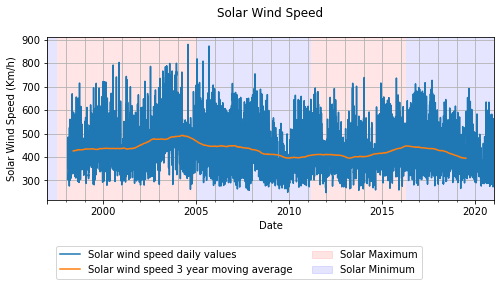

In [105]:
sws_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\solar_wind_speed\\solar_wind_speed.h5"
sws_file_ma = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\data_formatting\\solar_wind_speed\\solar_wind_speed.h5"
swsData = readH5File(sws_file)
swsData['moving_avg'] = swsData.rolling(window=3*365, min_periods=int(windowSize*60/100)).mean()
swsData['moving_avg'] = swsData['moving_avg'].shift(int(windowSize/2)*-1)

# swsData['moving_avg_cubic_interpolation'] = swsData['moving_avg'].interpolate(method='cubic')


ax = swsData.plot(figsize=(8, 3), legend=None)
ax.set_xlabel("Date")
ax.set_ylabel("Solar Wind Speed (Km/h)")
ax.grid('on', which='minor', axis='x' )
ax.grid('off', which='major', axis='x' )
ax.grid('on', which='minor', axis='y' )
ax.grid('off', which='major', axis='y' )

ax.axvspan('1997-01-01', '1997-07-18', facecolor='blue', alpha=0.1)
ax.axvspan('1997-07-18', '2005-01-20', facecolor='red', alpha=0.1)
ax.axvspan('2005-01-20', '2011-03-13', facecolor='blue', alpha=0.1)
ax.axvspan('2011-03-13', '2016-04-23', facecolor='red', alpha=0.1)
ax.axvspan('2016-04-23 ', '2020-12-31', facecolor='blue', alpha=0.1)

plt.title('Solar Wind Speed', pad=20)

ax.legend(framealpha=0.4)
red_line = Line2D([0], [0], color='tab:blue', label='Solar wind speed daily values')
green_line = Line2D([0], [0], color='tab:orange', label='Solar wind speed 3 year moving average')
# gray_patch = mpatches.Patch(color='gray', alpha=0.7, label='95% confidence interval')
red_patch = mpatches.Patch(color='red', alpha=0.1, label='Solar Maximum')
blue_patch = mpatches.Patch(color='blue', alpha=0.1, label='Solar Minimum')
lg = plt.legend(handles=[red_line, green_line, red_patch, blue_patch], ncol=2, bbox_to_anchor=(0.85, -0.25))


plt.savefig(final_plot_location + 'sws_smm.pdf', dpi=300, bbox_inches = "tight")


plt.show()

C:\Users\davi_fr\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\davi_fr\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


        corr_value
lag               
0.0       1.000000
1.0       0.793749
2.0       0.504853
3.0       0.301550
4.0       0.186345
...            ...
8761.0         NaN
8762.0         NaN
8763.0         NaN
8764.0         NaN
8765.0         NaN

[8766 rows x 1 columns]


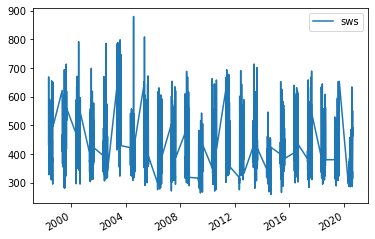

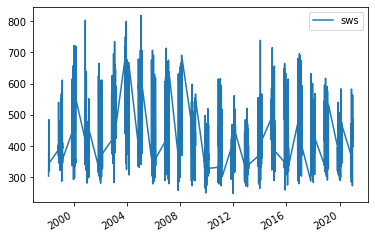

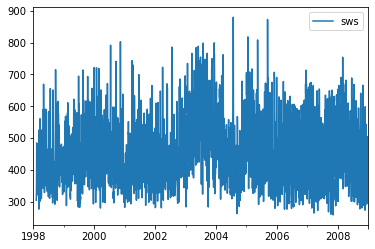

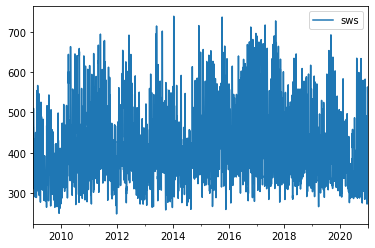

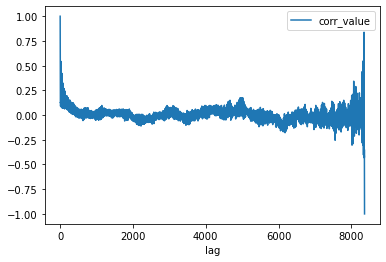

In [15]:
# swsDataAutocorr = swsData['sws'].autocorr(lag=1)

sws_summer = swsData[(swsData.index.month == 5) | 
                     (swsData.index.month == 6) |
                     (swsData.index.month == 7) | 
                     (swsData.index.month == 8)]

sws_summer.plot()

sws_winter = swsData[(swsData.index.month == 1) | 
                     (swsData.index.month == 2) |
                     (swsData.index.month == 11) | 
                     (swsData.index.month == 12)]

sws_winter.plot()

swscycle23 = swsData[(swsData.index >= '01-01-1998') & 
                     (swsData.index <= '31-12-2008')]

swscycle24 = swsData[(swsData.index >= '01-01-2009') & 
                     (swsData.index <= '31-12-2020')]

swscycle23.plot()

swscycle24.plot()

swsautocorrdf = pd.DataFrame()
for lag in np.arange(len(swsData)):
    swsDataAutocorr = swsData['sws'].autocorr(lag=lag)
    
    
    row = {'lag': lag, 
           'corr_value': swsDataAutocorr,
          }
    swsautocorrdf = swsautocorrdf.append(row, ignore_index=True)
swsautocorrdf = swsautocorrdf.set_index('lag')    
swsautocorrdf.plot()
print(swsautocorrdf)

In [25]:
def extractDataByDate(data, startDate, endDate):
    data.index =  pd.to_datetime(data.index, format='%Y-%m-%d')
    extData = data[(data.index.get_level_values('date') >= startDate) & 
                   (data.index.get_level_values('date') <= endDate)]
    return extData

sDate = '1998-01-01'
eDate = '2020-12-31'

In [47]:
windowSize = 3*365
movingAvgf10_7Data = f10_7Data.rolling(window=windowSize, min_periods=int(windowSize*60/100)).mean().shift(int(windowSize/2)*-1)
df = movingAvgf10_7Data

thr = 100
status = None

for ele in range(len(df)):
    currentStatus = df.iloc[ele].f10_7 > thr
    if status != currentStatus:
        status = currentStatus
        print(df.iloc[ele].name)
    



1997-01-01 00:00:00
1997-07-18 00:00:00
2005-01-20 00:00:00
2011-03-13 00:00:00
2016-04-23 00:00:00


### Correlation: F10.7 Solar Flux and Total Electron content at 52.5N

max:  0.8684663357735437
min:  -0.30503042953471754


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/davi_fr/Documents/Thesis Project Final/correlation_analysis_01122022/result_plots_2/corr_tec_f10_7_12.5N.png'

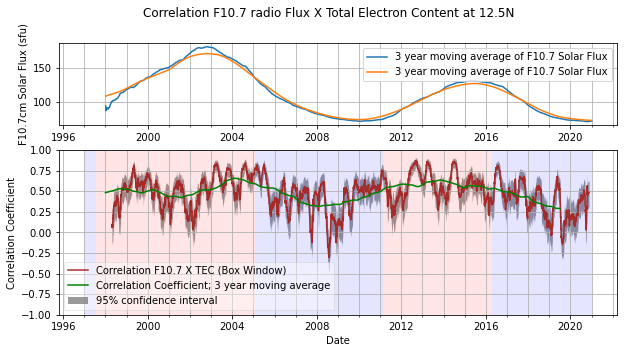

In [131]:
tec_f10_7_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\correlation\\tec_f10_7\\tec_f10_7.h5"
# tec_f10_7_norm_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\normalised_correlation\\tec_f10_7\\tec_f10_7.h5"
tec_f10_7_corrr_lowerLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\confidence_interval\\conf_int_corr_tec_f10_7\\conf_int_corr_tec_f10_7_lowerConfInterval.h5"
tec_f10_7_corrr_upperLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\confidence_interval\\conf_int_corr_tec_f10_7\\conf_int_corr_tec_f10_7_upperConfInterval.h5"

tec_f10_7_corrr = readH5File(tec_f10_7_corrr_file)
# tec_f10_7_norm_corrr = readH5File(tec_f10_7_norm_corrr_file)
tec_f10_7_corrr_lowerLimit = readH5File(tec_f10_7_corrr_lowerLimitFile)
tec_f10_7_corrr_upperLimit = readH5File(tec_f10_7_corrr_upperLimitFile)


tec_f10_7_corrr = extractDataByDate(tec_f10_7_corrr, sDate, eDate)
# tec_f10_7_norm_corrr = extractDataByDate(tec_f10_7_norm_corrr, sDate, eDate)
tec_f10_7_corrr_lowerLimit = extractDataByDate(tec_f10_7_corrr_lowerLimit, sDate, eDate)
tec_f10_7_corrr_upperLimit = extractDataByDate(tec_f10_7_corrr_upperLimit, sDate, eDate)


f10_7Data = extractDataByDate(f10_7Data, sDate, eDate)
# print(extractDataByDate(tec_f10_7_corrr, sDate, eDate))

mv_period = 3
mv_period_2 = 3

lat = 12.5
tec_f10_7_corrr = tec_f10_7_corrr[[lat]]
# tec_f10_7_norm_corrr = tec_f10_7_norm_corrr[lat]
tec_f10_7_corrr_lowerLimit = tec_f10_7_corrr_lowerLimit[lat]
tec_f10_7_corrr_upperLimit = tec_f10_7_corrr_upperLimit[lat]


print('max: ', tec_f10_7_corrr.max().max())
print('min: ', tec_f10_7_corrr.min().min())

movingAvgCorr = tec_f10_7_corrr.rolling(window=int(365*mv_period), min_periods=5).mean().shift(int((365*mv_period)/2)*-1)
movingAvgf10_7Data = f10_7Data.rolling(window=int(365*mv_period_2), min_periods=5).mean()

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [1, 2]})
fig.suptitle('Correlation F10.7 radio Flux X Total Electron Content at {}{}'.format(lat, 'N' if lat >= 0 else 'S'))
fig.set_size_inches(10, 5)
axs[0].xaxis.set_tick_params(which='both', labelbottom=True)
axs[0].plot(movingAvgf10_7Data, label='{} year moving average of F10.7 Solar Flux'.format(mv_period_2))
axs[0].grid('on', which='minor')
axs[0].grid('off', which='major')
axs[0].xaxis.set_minor_locator(AutoMinorLocator(5))

axs[1].plot(tec_f10_7_corrr, label='Correlation F10.7 X TEC (Box Window)', color="brown", alpha=1)
axs[1].plot(movingAvgCorr, label='Correlation Coefficient; {} year moving average'.format(mv_period), color="green", alpha=1)
# axs[1].plot(tec_f10_7_corrr)
# axs[1].plot(tec_f10_7_corrr)

axs[1].grid('on', which='minor')
axs[1].grid('off', which='major')
axs[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs[1].set_ylim(-1,1)

axs[1].axvspan('1997-01-01', '1997-07-18', facecolor='blue', alpha=0.1)
axs[1].axvspan('1997-07-18', '2005-01-20', facecolor='red', alpha=0.1)
axs[1].axvspan('2005-01-20', '2011-03-13', facecolor='blue', alpha=0.1)
axs[1].axvspan('2011-03-13', '2016-04-23', facecolor='red', alpha=0.1)
axs[1].axvspan('2016-04-23', '2020-12-31', facecolor='blue', alpha=0.1)

xAxis = tec_f10_7_corrr_lowerLimit.index
                
yAxisLower = tec_f10_7_corrr_lowerLimit
yAxisUpper = tec_f10_7_corrr_upperLimit
axs[1].fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.8, linewidth=0, color='gray', label='95% confidence interval')


axs[1].set_xlabel('Date')
axs[1].set_ylabel('Correlation Coefficient')
axs[0].set_ylabel('F10.7cm Solar Flux (sfu)')

axs[1].legend(framealpha=0.4)
line_1 = mpatches.Patch(linestyle='-', color='brown', label='Correlation F10.7 X TEC (Box Window)')
line_2 = mpatches.Patch(linestyle='-', color='green', label='Correlation Coefficient; {} year moving average'.format(mv_period))
line_fill = mpatches.Patch(color='gray', alpha=0.8, label='95% confidence interval')
red_patch = mpatches.Patch(color='red', alpha=0.1, label='Solar Maximum')
blue_patch = mpatches.Patch(color='blue', alpha=0.1, label='Solar Minimum')

# axs[1].legend(handles=[line_1, line_2, line_fill, red_patch, blue_patch])


axs[0].legend()       
# plt.savefig('Correlation F10.7 radio Flux X Total Electron Content at 60N.png', dpi=300)
plt.savefig(final_plot_location + 'corr_tec_f10_7_{}{}.png'.format(lat, 'N' if lat >= 0 else 'S'), dpi=150, bbox_inches = "tight")
plt.show()



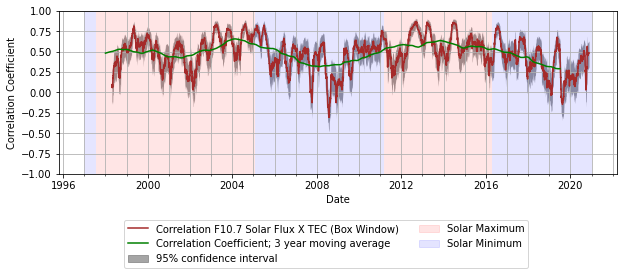

In [133]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 3)


ax.plot(tec_f10_7_corrr, label='Correlation F10.7 Solar Flux X TEC (Box Window)', color="brown", alpha=1)
ax.plot(movingAvgCorr, label='Correlation Coefficient; {} year moving average'.format(mv_period), color="green", alpha=1)


ax.grid('on', which='minor')
ax.grid('off', which='major')
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylim(-1,1)

ax.axvspan('1997-01-01', '1997-07-18', facecolor='blue', alpha=0.1)
ax.axvspan('1997-07-18', '2005-01-20', facecolor='red', alpha=0.1)
ax.axvspan('2005-01-20', '2011-03-13', facecolor='blue', alpha=0.1)
ax.axvspan('2011-03-13', '2016-04-23', facecolor='red', alpha=0.1)
ax.axvspan('2016-04-23', '2020-12-31', facecolor='blue', alpha=0.1)

xAxis = tec_f10_7_corrr_lowerLimit.index
                
yAxisLower = tec_f10_7_corrr_lowerLimit
yAxisUpper = tec_f10_7_corrr_upperLimit
ax.fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.8, linewidth=0, color='gray', label='95% confidence interval')


ax.set_xlabel('Date')
ax.set_ylabel('Correlation Coefficient')

ax.legend(framealpha=0.4)
red_line = Line2D([0], [0], color='brown', label='Correlation F10.7 Solar Flux X TEC (Box Window)')
green_line = Line2D([0], [0], color='green', label='Correlation Coefficient; {} year moving average'.format(mv_period))
gray_patch = mpatches.Patch(color='gray', alpha=0.7, label='95% confidence interval')
red_patch = mpatches.Patch(color='red', alpha=0.1, label='Solar Maximum')
blue_patch = mpatches.Patch(color='blue', alpha=0.1, label='Solar Minimum')
lg = plt.legend(handles=[red_line, green_line, gray_patch, red_patch, blue_patch], ncol=2, bbox_to_anchor=(0.85, -0.25))

# axs[1].legend(handles=[line_1, line_2, line_fill, red_patch, blue_patch])


# plt.savefig('Correlation F10.7 radio Flux X Total Electron Content at 60N.png', dpi=300)
plt.savefig(final_plot_location + 'corr_tec_f10_7_{}{}.pdf'.format(lat, 'N' if lat >= 0 else 'S'), dpi=150, bbox_inches = "tight")
plt.show()

### Correlation: Solar Wind Speed and Total Electron content at 52.5N

High:  0.787398363700749
Low:  -0.6129563307221415
D


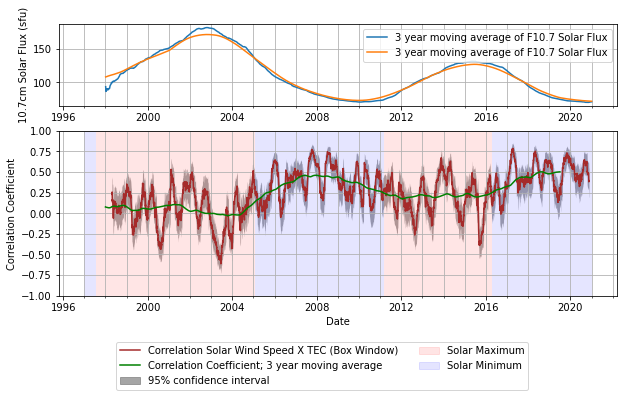

In [134]:
meanCorrelation = readH5File('mean_correlation_latitude_all_window_size.h5')
meanCorrelationsws = meanCorrelation[(52.5,'correlation_sws_rel_diff')]
meanCorrealtionsws = meanCorrelationsws.loc[90]
# print(meanCorrelation[(52.5,'correlation_sws_rel_diff')])
# print(meanCorrealtionsws)


tec_sws_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\correlation\\tec_sws\\tec_sws.h5"
# tec_sws_norm_corrr_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\normalised_correlation\\tec_sws\\tec_sws.h5"
tec_sws_corrr_lowerLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\confidence_interval\\conf_int_corr_tec_sws\\conf_int_corr_tec_sws_lowerConfInterval.h5"
tec_sws_corrr_upperLimitFile = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\confidence_interval\\conf_int_corr_tec_sws\\conf_int_corr_tec_sws_upperConfInterval.h5"

tec_sws_corrr = readH5File(tec_sws_corrr_file)
# tec_sws_norm_corrr = readH5File(tec_sws_norm_corrr_file)
tec_sws_corrr_lowerLimit = readH5File(tec_sws_corrr_lowerLimitFile)
tec_sws_corrr_upperLimit = readH5File(tec_sws_corrr_upperLimitFile)



tec_sws_corrr = extractDataByDate(tec_sws_corrr, sDate, eDate)
# tec_sws_norm_corrr = extractDataByDate(tec_sws_norm_corrr, sDate, eDate)
tec_sws_corrr_lowerLimit = extractDataByDate(tec_sws_corrr_lowerLimit, sDate, eDate)
tec_sws_corrr_upperLimit = extractDataByDate(tec_sws_corrr_upperLimit, sDate, eDate)


lat = 12.5
tec_sws_corrr = tec_sws_corrr[lat]
peakValue = tec_sws_corrr.max()
print('High: ', peakValue)
print('Low: ', tec_sws_corrr.min())

frequency = pd.infer_freq(tec_sws_corrr.index)
print(frequency)

# tec_sws_norm_corrr = tec_sws_norm_corrr[lat]
tec_sws_corrr_lowerLimit = tec_sws_corrr_lowerLimit[lat]
tec_sws_corrr_upperLimit = tec_sws_corrr_upperLimit[lat]
mv_period = 3
movingAvgCorr = tec_sws_corrr.rolling(window=int(365*mv_period), min_periods=5).mean().shift(int((365*mv_period)/2)*-1)
movingAvgf10_7Data = f10_7Data.rolling(window=int(365*mv_period_2), min_periods=5).mean()


fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [1, 2]})
figTitle = 'Correlation Solar Wind Speed X Total Electron Content at ' + str(lat) + 'N' if lat >= 0 else 'S'
# fig.suptitle(figTitle)
fig.set_size_inches(10, 5)
axs[0].xaxis.set_tick_params(which='both', labelbottom=True)
axs[0].plot(movingAvgf10_7Data, label='{} year moving average of F10.7 Solar Flux'.format(mv_period_2))
axs[0].grid('on', which='minor')
axs[0].grid('off', which='major')
axs[0].xaxis.set_minor_locator(AutoMinorLocator(4))

axs[1].plot(tec_sws_corrr, label='Correlation Solar Wind Speed X TEC (Box Window)', color="brown")

axs[1].plot(movingAvgCorr, label='Correlation Coefficient; {} year moving average'.format(mv_period), color="green", alpha=1)

axs[1].grid('on', which='minor')
axs[1].grid('off', which='major')
axs[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs[1].set_ylim(-1,1)

axs[1].axvspan('1997-01-01', '1997-07-18', facecolor='blue', alpha=0.1)
axs[1].axvspan('1997-07-18', '2005-01-20', facecolor='red', alpha=0.1)
axs[1].axvspan('2005-01-20', '2011-03-13', facecolor='blue', alpha=0.1)
axs[1].axvspan('2011-03-13', '2016-04-23', facecolor='red', alpha=0.1)
axs[1].axvspan('2016-04-23', '2020-12-31', facecolor='blue', alpha=0.1)
# axs[1].axvspan('1998-01-01', '2004-12-31', facecolor='red', alpha=0.2)

xAxis = tec_sws_corrr_lowerLimit.index
                
yAxisLower = tec_sws_corrr_lowerLimit
yAxisUpper = tec_sws_corrr_upperLimit
axs[1].fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.7, linewidth=0, color='gray', label='95% confidence interval')

axs[1].set_xlabel('Date')
axs[1].set_ylabel('Correlation Coefficient')
axs[0].set_ylabel('10.7cm Solar Flux (sfu)')


axs[1].legend(framealpha=0.4)
axs[0].legend() 

red_line = Line2D([0], [0], color='brown', label='Correlation Solar Wind Speed X TEC (Box Window)')
green_line = Line2D([0], [0], color='green', label='Correlation Coefficient; {} year moving average'.format(mv_period))
gray_patch = mpatches.Patch(color='gray', alpha=0.7, label='95% confidence interval')
red_patch = mpatches.Patch(color='red', alpha=0.1, label='Solar Maximum')
blue_patch = mpatches.Patch(color='blue', alpha=0.1, label='Solar Minimum')
lg = plt.legend(handles=[red_line, green_line, gray_patch, red_patch, blue_patch], ncol=2, bbox_to_anchor=(0.85, -0.25))

# axs[1].add_artist(lg)
# plt.savefig('Correlation Solar Wind Speed X Total Electron Content at 60N.png', dpi=300)
# plt.savefig(final_plot_location + 'corr_tec_sws_' + str(lat) + '.png', dpi=150, bbox_inches = "tight")
plt.show()


# Getting only the axes specified by ax[0,0]
extent = axs[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())

# Saving it to a pdf file. 
# axs[1].figure.savefig(final_plot_location + 'corr_sws.pdf')

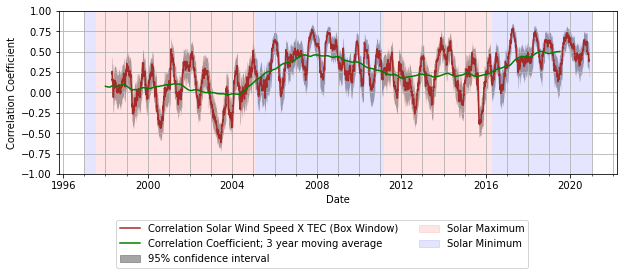

In [135]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 3)
ax.plot(tec_sws_corrr, label='Correlation Solar Wind Speed X TEC (Box Window)', color="brown")

ax.plot(movingAvgCorr, label='Correlation Coefficient; {} year moving average'.format(mv_period), color="green", alpha=1)

ax.grid('on', which='minor')
ax.grid('off', which='major')
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylim(-1,1)
ax.axvspan('1997-01-01', '1997-07-18', facecolor='blue', alpha=0.1)
ax.axvspan('1997-07-18', '2005-01-20', facecolor='red', alpha=0.1)
ax.axvspan('2005-01-20', '2011-03-13', facecolor='blue', alpha=0.1)
ax.axvspan('2011-03-13', '2016-04-23', facecolor='red', alpha=0.1)
ax.axvspan('2016-04-23', '2020-12-31', facecolor='blue', alpha=0.1)
# axs[1].axvspan('1998-01-01', '2004-12-31', facecolor='red', alpha=0.2)

xAxis = tec_sws_corrr_lowerLimit.index
                
yAxisLower = tec_sws_corrr_lowerLimit
yAxisUpper = tec_sws_corrr_upperLimit
ax.fill_between(xAxis, yAxisLower, yAxisUpper, alpha=.7, linewidth=0, color='gray', label='95% confidence interval')

ax.set_xlabel('Date')
ax.set_ylabel('Correlation Coefficient')


ax.legend(framealpha=0.4)

red_line = Line2D([0], [0], color='brown', label='Correlation Solar Wind Speed X TEC (Box Window)')
green_line = Line2D([0], [0], color='green', label='Correlation Coefficient; {} year moving average'.format(mv_period))
gray_patch = mpatches.Patch(color='gray', alpha=0.7, label='95% confidence interval')
red_patch = mpatches.Patch(color='red', alpha=0.1, label='Solar Maximum')
blue_patch = mpatches.Patch(color='blue', alpha=0.1, label='Solar Minimum')
lg = plt.legend(handles=[red_line, green_line, gray_patch, red_patch, blue_patch], ncol=2, bbox_to_anchor=(0.85, -0.25))

# axs[1].add_artist(lg)
# plt.savefig('Correlation Solar Wind Speed X Total Electron Content at 60N.png', dpi=300)
plt.savefig(final_plot_location + 'corr_tec_sws_' + str(lat) + '.pdf', dpi=150, bbox_inches = "tight")
plt.show()


# Getting only the axes specified by ax[0,0]
# extent = axs[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())

### Correlation F10.7 Solar Flux Total Electron Content Seasonal Dependancy

In [143]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def findBounds(a, b):
    boundValue = a if a > b else b
    if a < 0:
        a = a * -1
    if b < 0:
        b = b* -1
    boundValue = a if a > b else b
    bounds = np.linspace(-boundValue,boundValue,10)
    print(boundValue)
    return bounds

def getCorrelationBounds(df):
    maxValue = df.max().max()
    minValue = df.min().min()
#     print(maxValue, minValue)
    maxValue = maxValue + 0.1
    minValue = minValue - 0.1
    maxValue = round(maxValue, 1)
    minValue = round(minValue, 1)
    # print(maxValue, minValue)
    bounds = findBounds(minValue, maxValue)
    # bounds = np.linspace(minValue,maxValue,10)
    # bounds = np.linspace(-1,+1,20)
    
    return bounds

def plotSeasonalMap(df, title):
    indexValues = df.index.values
    tiks = range(0,71,10)
    lbl = indexValues[tiks]

    x_tiks = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]#range(0, 366, 30)
    x_bl = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
            'August', 'September', 'October', 'November', 'December']
    plt.figure(figsize=(9, 4))
    plt.pcolormesh(df, cmap='seismic')
    cbar = plt.colorbar()
    plt.yticks(ticks=tiks, labels=lbl)
    plt.xticks(ticks=x_tiks, labels=x_bl, rotation=45)
    bounds = getCorrelationBounds(df)
    plt.clim(bounds.min(),bounds.max())
    plt.clim(-0.7,0.7)
    plt.xlabel('Month')
    plt.ylabel('Latitude')
    cbar.set_label('Correlation Coefficient')
#     plt.title(title, pad=20)    
    
    return True


def is_leap_and_29Feb(s):
    return (s.index.year % 4 == 0) & ((s.index.year % 100 != 0) | (s.index.year % 400 == 0)) & (s.index.month == 2) & (s.index.day == 29)

0.5813994467104611 0.11109852153014076
0.7


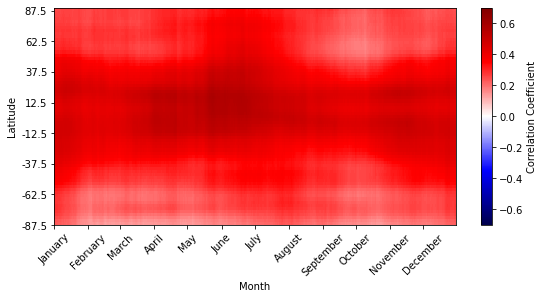

In [144]:
# _corr_tec_f10_7_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_tec_f10_7_seasonal.h5'
_corr_norm_tec_f10_7_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_norm_tec_f10_7_seasonal.h5'

_corr_tec_f10_7_seasonal = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\mean\\seasonal_mean_corr_tex_x_f10_7\\seasonal_mean_corr_tex_x_f10_7.h5"

g_corr_f10_day_mean = readH5File(_corr_norm_tec_f10_7_seasonal)

corr_f10_day_mean = readH5File(_corr_tec_f10_7_seasonal)
print(corr_f10_day_mean.max().max(), corr_f10_day_mean.min().min())
corr_f10_day_mean = corr_f10_day_mean.drop((2,29))
g_corr_f10_day_mean = g_corr_f10_day_mean.T
corr_f10_day_mean = corr_f10_day_mean.T

# plotSeasonalMap(g_corr_f10_day_mean, 'Normalised correlation map TEC x f10.7')
plotSeasonalMap(corr_f10_day_mean, 'Correlation of F10.7 Solar Flux and Total Electron Content\nSeasonal Mean 1998 - 2020')



# indexValues = corr_f10_day_mean.index.values
# tiks = range(0,71,10)
# lbl = indexValues[tiks]
    
# x_tiks = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]#range(0, 366, 30)
# x_bl = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
#             'August', 'September', 'October', 'November', 'December']
    
    
# plt.figure(figsize=(9, 4))
# plt.pcolormesh(corr_f10_day_mean, cmap='seismic')
# cbar = plt.colorbar()
# plt.yticks(ticks=tiks, labels=lbl)
# plt.xticks(ticks=x_tiks, labels=x_bl, rotation=45)
# bounds = getCorrelationBounds(corr_f10_day_mean)
# plt.clim(bounds.min(),bounds.max())
# plt.xlabel('Month')
# plt.ylabel('Latitude')
# cbar.set_label('Correlation Coefficient')
# plt.title("Correlation of F10.7 Solar Flux and Total Electron Content Seasonal Mean 1998 - 2020")

plt.savefig(final_plot_location + 'corr_tec_f10_7_seasonal_map.pdf', dpi=150, bbox_inches = "tight")
plt.show()

### Correlation Solar Wind Speed Total Electron Content Seasonal Dependancy

month  day
11     4     -0.476935
       5     -0.475608
       3     -0.475384
       1     -0.473657
       2     -0.472822
                ...   
3      13    -0.248397
       17    -0.245244
       14    -0.240242
       15    -0.233623
       16    -0.233495
Length: 365, dtype: float64
0.371242174809867 -0.4769351685741615
0.6


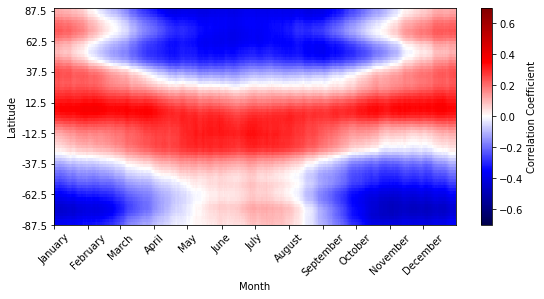

In [145]:
# _corr_tec_sws_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_tec_sws_seasonal.h5'
_corr_tec_sws_seasonal = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\correlation_analysis_01122022\\computations\\mean\\seasonal_mean_corr_tex_x_sws\\seasonal_mean_corr_tex_x_sws.h5"
_corr_norm_tec_sws_seasonal = 'C:/Users/davi_fr/Documents/Thesis Project Final/data/correlation_seasonal_data/corr_norm_tec_sws_seasonal.h5'

g_corr_sws_day_mean = readH5File(_corr_norm_tec_sws_seasonal)
corr_sws_day_mean = readH5File(_corr_tec_sws_seasonal)

corr_sws_day_mean = corr_sws_day_mean.drop((2,29))
g_corr_sws_day_mean = g_corr_sws_day_mean.T

print(corr_sws_day_mean.T.min().sort_values())
print(corr_sws_day_mean.max().max(), corr_sws_day_mean.min().min())

corr_sws_day_mean = corr_sws_day_mean.T

# plotSeasonalMap(g_corr_sws_day_mean, 'Normalised correlation map TEC x solar wind speed', np.linspace(-0.5,0.5,10))
plotSeasonalMap(corr_sws_day_mean, 'Correlation of Solar Wind Speed and Total Electron Content\nSeasonal Mean 1998 - 2020')

plt.savefig(final_plot_location + 'corr_tec_sws_seasonal_map.pdf', dpi=150, bbox_inches = "tight")
plt.show()

### Correlation F10.7 Solar Flux Total Electron Content UT

In [32]:
tec_rel_diff = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\tec"
tec_rel_diff_data = pd.DataFrame()
for year in analysisPeriod:
    tec_file_path = tec_rel_diff + "\\" + str(year) + ".h5"
    tecData = readH5File(tec_file_path)
    tecData = tecData[[(52.5, 15)]]
    tecData = tecData.unstack()
    tec_rel_diff_data = tec_rel_diff_data.append(tecData)
    
    
tec_rel_diff_data = tec_rel_diff_data.stack()
tec_rel_diff_data = tec_rel_diff_data.interpolate()
tec_rel_diff_data = tec_rel_diff_data.unstack()

tec_rel_diff_data.index = pd.to_datetime(tec_rel_diff_data.index)
tec_rel_diff_data.columns = tec_rel_diff_data.columns.droplevel()
tec_rel_diff_data.columns = tec_rel_diff_data.columns.droplevel()
print(tec_rel_diff_data)

f10_7_rel_diff_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\f10_7\\f10_7.h5"
f10_7_rel_diff = readH5File(f10_7_rel_diff_file)
print(f10_7_rel_diff)

sws_rel_diff_file = "C:\\Users\\davi_fr\\Documents\\Thesis Project Final\\tets folder main\\test\\computations\\relative_difference\\sws\\sws.h5"
sws_rel_diff = readH5File(sws_rel_diff_file)
print(sws_rel_diff)

tec_52_5_15_f10_7_correlation = tec_rel_diff_data.rolling(90).corr(f10_7_rel_diff['f10_7'])
tec_52_5_15_sws_correlation = tec_rel_diff_data.rolling(90).corr(sws_rel_diff['sws'])

print(tec_52_5_15_f10_7_correlation)
print(tec_52_5_15_sws_correlation)

ut           00:00:00   01:00:00   02:00:00   03:00:00  04:00:00   05:00:00  \
date                                                                          
1998-06-20        NaN -18.562872        NaN -26.717560       NaN -16.694661   
1998-06-21        NaN   3.984062        NaN   2.662152       NaN   5.837322   
1998-06-22        NaN -14.551423        NaN -19.962686       NaN -20.196740   
1998-06-23        NaN  -3.563941        NaN -15.274037       NaN  -3.799706   
1998-06-24        NaN -20.932590        NaN -18.749999       NaN -22.690990   
...               ...        ...        ...        ...       ...        ...   
2020-12-27 -11.787318 -14.775019 -11.738483  -9.713380 -6.574394 -12.115736   
2020-12-28 -11.218571 -26.380367 -11.778112  -2.095084  1.752853  13.632202   
2020-12-29 -11.008570 -27.388535   4.667723   4.876029 -5.096660   7.511314   
2020-12-30   8.737202  -6.691179  24.313405  24.267783  9.330985  11.690644   
2020-12-31 -10.497235 -20.177383   6.607576   3.4138

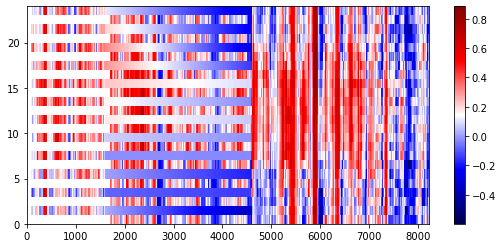

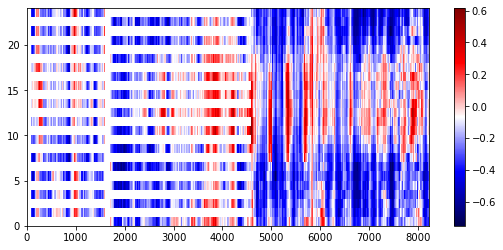

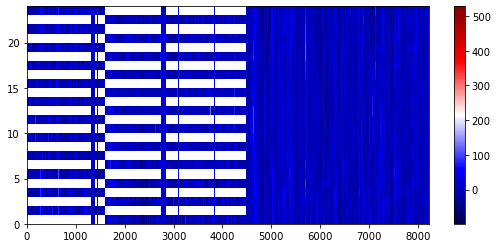

In [39]:

# print(tec_52_5_15_f10_7_correlation.interpolate().isna())
# print(f10_7_rel_diff[f10_7_rel_diff.isnull().any(axis=1)])
# print(sws_rel_diff[sws_rel_diff.isnull().any(axis=1)])
plt.figure(figsize=(9, 4))
plt.pcolormesh(tec_52_5_15_f10_7_correlation.interpolate().T, cmap='seismic')
cbar = plt.colorbar()

plt.show


plt.figure(figsize=(9, 4))
plt.pcolormesh(tec_52_5_15_sws_correlation.T, cmap='seismic')
cbar = plt.colorbar()

plt.show()



plt.figure(figsize=(9, 4))
plt.pcolormesh(tec_rel_diff_data.T, cmap='seismic')
cbar = plt.colorbar()

plt.show()

### Histogram of correlation at 52.5 N

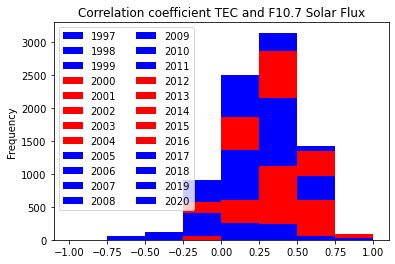

date
1997-01-01         NaN
1997-01-02         NaN
1997-01-03         NaN
1997-01-04         NaN
1997-01-05         NaN
                ...   
2020-12-27   -0.307999
2020-12-28   -0.255857
2020-12-29   -0.222242
2020-12-30   -0.196888
2020-12-31   -0.182850
Name: 52.5, Length: 8766, dtype: float64
date
1997-01-01         NaN
1997-01-02         NaN
1997-01-03         NaN
1997-01-04         NaN
1997-01-05         NaN
                ...   
2020-12-27   -0.307999
2020-12-28   -0.255857
2020-12-29   -0.222242
2020-12-30   -0.196888
2020-12-31   -0.182850
Name: 52.5, Length: 8766, dtype: float64
date
1997-01-01 00:00:00                                                  NaN
1997-01-02 00:00:00                                                  NaN
1997-01-03 00:00:00                                                  NaN
1997-01-04 00:00:00                                                  NaN
1997-01-05 00:00:00                                                  NaN
                                

AttributeError: 'Index' object has no attribute 'month'

In [91]:

# colors = plt.cm.rainbow(np.linspace(0, 1, 2))

colors = ['blue', 'blue','blue','red','red', 'red','red', 'red','blue','blue','blue','blue','blue','blue','blue','red','red','red','red','red','blue','blue','blue','blue']







tec_f10_7_corrr_yearly = tec_f10_7_corrr.copy()
tec_f10_7_corrr_yearly.index = pd.to_datetime(tec_f10_7_corrr_yearly.index, format='%Y-%m-%d')
# print(tec_sws_corrr_datesplit)
tec_f10_7_corrr_yearly['day'] = tec_f10_7_corrr_yearly.index.day
# print(tec_sws_corrr_datesplit)
tec_f10_7_corrr_yearly['month'] = tec_f10_7_corrr_yearly.index.month
tec_f10_7_corrr_yearly['year'] = tec_f10_7_corrr_yearly.index.year
tec_f10_7_corrr_yearly = tec_f10_7_corrr_yearly.reset_index().drop('date', axis=1).set_index(['day', 'month', 'year']).unstack('year')




# print(tec_f10_7_corrr_yearly)
tec_f10_7_corrr_yearly.plot.hist(bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], stacked = True, color=colors)
plt.legend([1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020], ncol=2)
plt.title('Correlation coefficient TEC and F10.7 Solar Flux')
plt.show()





print(tec_sws_corrr)
tec_sws_corrr_yearly = tec_sws_corrr.copy()
tec_sws_corrr_yearly.index = pd.to_datetime(tec_sws_corrr_yearly.index, format='%Y-%m-%d')
print(tec_sws_corrr_yearly)
tec_sws_corrr_yearly['day'] = tec_sws_corrr_yearly.index.day
print(tec_sws_corrr_yearly)
tec_sws_corrr_yearly['month'] = tec_sws_corrr_yearly.index.month
tec_sws_corrr_yearly['year'] = tec_sws_corrr_yearly.index.year
tec_sws_corrr_yearly = tec_sws_corrr_yearly.reset_index().drop('date', axis=1).set_index(['day', 'month', 'year']).unstack('year')




# print(tec_sws_corrr_yearly)
tec_sws_corrr_yearly.plot.hist(bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], stacked = True, color=colors)
plt.legend([1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020], ncol=2)
plt.title('Correlation coefficient TEC and Solar Wind Speed')
plt.show()

In [116]:
doy = np.arange(1, 366)
        
doyArray = np.array_split(doy, 12)
df = pd.DataFrame(doyArray).T
df.columns = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
            'August', 'September', 'October', 'November', 'December']
# print(df)
print(df.min())
print(df.max())


January        1.0
February      32.0
March         63.0
April         94.0
May          125.0
June         156.0
July         186.0
August       216.0
September    246.0
October      276.0
November     306.0
December     336.0
dtype: float64
January       31.0
February      62.0
March         93.0
April        124.0
May          155.0
June         185.0
July         215.0
August       245.0
September    275.0
October      305.0
November     335.0
December     365.0
dtype: float64


### Correlation of Solar Wind and TEX during major solar storm event.

               sws
1997-01-01     NaN
1997-01-02     NaN
1997-01-03     NaN
1997-01-04     NaN
1997-01-05     NaN
...            ...
2020-12-27  463.09
2020-12-28  486.17
2020-12-29  467.50
2020-12-30  478.41
2020-12-31  398.60

[8766 rows x 1 columns]
                 0.0
date                
2000-07-14 -0.072101
2000-07-15 -0.078074
2000-07-16 -0.083402
2000-07-17 -0.088033
2000-07-18 -0.091918
2000-07-19 -0.095014
2000-07-20 -0.097281
2000-07-21 -0.098689
2000-07-22 -0.099211
2000-07-23 -0.098831
2000-07-24 -0.097540


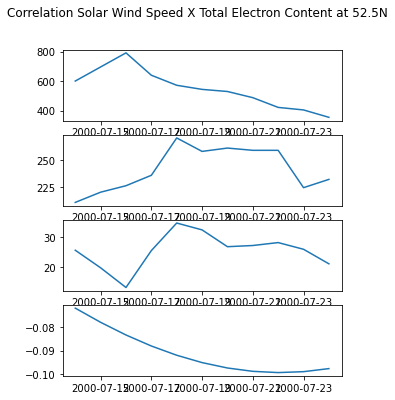

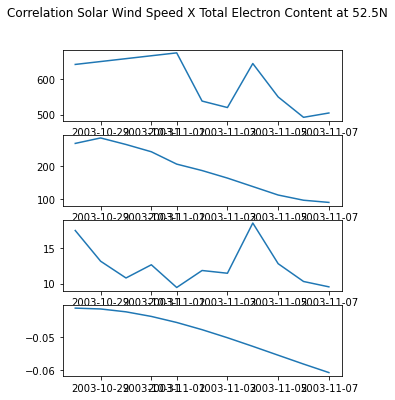

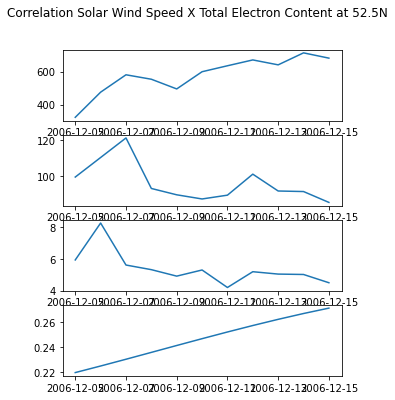

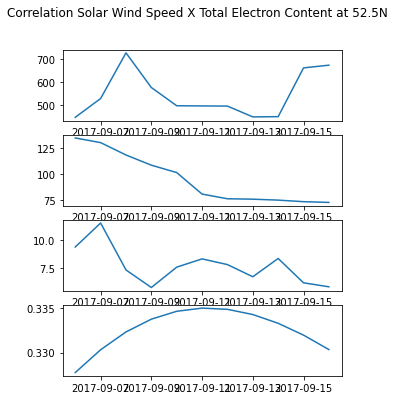

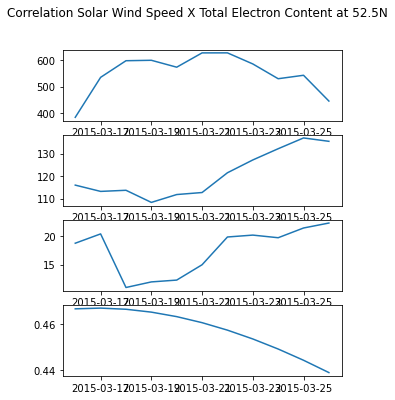

In [178]:
def date_aft_date(date, n):
    end_date = datetime.strptime(date, "%Y-%m-%d") + dt.timedelta(days=n)
    return end_date

n=10
tec_sws_norm_corrr_major_storm = pd.DataFrame(readH5File(tec_sws_norm_corrr_file)[0])
print(swsData)
tec_sws_norm_corrr_major_storm.index = pd.to_datetime(tec_sws_norm_corrr_major_storm.index, format='%Y-%m-%d')
storm_1_date = '2000-07-14' #2000: THE BASTILLE DAY EVENT
storm_2_date = '2003-10-28' #2003: THE HAUNTING HALLOWEEN STORMS
storm_3_date = '2006-12-05' #2006: X-RAY SUN FLARE FOR XMAS
storm_4_date = '2017-09-06'
storm_5_date = '2015-03-16' #The St. Patrick’s Day storm

# fig, axs = plt.subplots(2,3)
# fig.suptitle('Correlation Solar Wind Speed X Total Electron Content at 52.5N')
# fig.set_size_inches(8, 5)

# axs[0][0].plot(tec_sws_norm_corrr_major_storm.loc[storm_1_date:date_aft_date(storm_1_date, 10)])
# axs[0][1].plot(tec_sws_norm_corrr_major_storm.loc[storm_2_date:date_aft_date(storm_2_date, 10)])
# axs[0][2].plot(tec_sws_norm_corrr_major_storm.loc[storm_5_date:date_aft_date(storm_5_date, 10)])
# axs[1][0].plot(tec_sws_norm_corrr_major_storm.loc[storm_3_date:date_aft_date(storm_3_date, 10)])
# axs[1][1].plot(tec_sws_norm_corrr_major_storm.loc[storm_4_date:date_aft_date(storm_4_date, 10)])




fig, axs = plt.subplots(4)
fig.suptitle('Correlation Solar Wind Speed X Total Electron Content at 0N')
fig.set_size_inches(5, 6)

axs[0].plot(swsData.loc[storm_1_date:date_aft_date(storm_1_date, 10)])
axs[1].plot(f10_7Data.loc[storm_1_date:date_aft_date(storm_1_date, 10)])
axs[2].plot(tec_data_og.loc[storm_1_date:date_aft_date(storm_1_date, 10)])
axs[3].plot(tec_sws_norm_corrr_major_storm.loc[storm_1_date:date_aft_date(storm_1_date, 10)])

plt.plot()

fig, axs = plt.subplots(4)
fig.suptitle('Correlation Solar Wind Speed X Total Electron Content at 0')
fig.set_size_inches(5, 6)

axs[0].plot(swsData.loc[storm_2_date:date_aft_date(storm_2_date, 10)])
axs[1].plot(f10_7Data.loc[storm_2_date:date_aft_date(storm_2_date, 10)])
axs[2].plot(tec_data_og.loc[storm_2_date:date_aft_date(storm_2_date, 10)])
axs[3].plot(tec_sws_norm_corrr_major_storm.loc[storm_2_date:date_aft_date(storm_2_date, 10)])

plt.plot()

fig, axs = plt.subplots(4)
fig.suptitle('Correlation Solar Wind Speed X Total Electron Content at 0N')
fig.set_size_inches(5, 6)
axs[0].plot(swsData.loc[storm_3_date:date_aft_date(storm_3_date, 10)])
axs[1].plot(f10_7Data.loc[storm_3_date:date_aft_date(storm_3_date, 10)])
axs[2].plot(tec_data_og.loc[storm_3_date:date_aft_date(storm_3_date, 10)])
axs[3].plot(tec_sws_norm_corrr_major_storm.loc[storm_3_date:date_aft_date(storm_3_date, 10)])

plt.plot()

fig, axs = plt.subplots(4)
fig.suptitle('Correlation Solar Wind Speed X Total Electron Content at 0')
fig.set_size_inches(5, 6)
axs[0].plot(swsData.loc[storm_4_date:date_aft_date(storm_4_date, 10)])
axs[1].plot(f10_7Data.loc[storm_4_date:date_aft_date(storm_4_date, 10)])
axs[2].plot(tec_data_og.loc[storm_4_date:date_aft_date(storm_4_date, 10)])
axs[3].plot(tec_sws_norm_corrr_major_storm.loc[storm_4_date:date_aft_date(storm_4_date, 10)])

plt.plot()
fig, axs = plt.subplots(4)
fig.suptitle('Correlation Solar Wind Speed X Total Electron Content at 0')
fig.set_size_inches(5, 6)
axs[0].plot(swsData.loc[storm_5_date:date_aft_date(storm_5_date, 10)])
axs[1].plot(f10_7Data.loc[storm_5_date:date_aft_date(storm_5_date, 10)])
axs[2].plot(tec_data_og.loc[storm_5_date:date_aft_date(storm_5_date, 10)])
axs[3].plot(tec_sws_norm_corrr_major_storm.loc[storm_5_date:date_aft_date(storm_5_date, 10)])

plt.plot()
print(tec_sws_norm_corrr_major_storm.loc[storm_1_date:date_aft_date(storm_1_date, 10)])

In [128]:
d = pd.DataFrame(np.arange(0.01, 0.8, 0.003))[0:10]
# d = d[:10].reset_index()

m = d.rolling(4, min_periods=2).mean().shift(-2)
print(m)
e = pd.DataFrame(np.arange(0.3, 0.6, 0.003))[:10].reset_index()
# print(d,e)
co = d.rolling(4).corr(e).shift(-3)
# print(co)

        0
0  0.0130
1  0.0145
2  0.0175
3  0.0205
4  0.0235
5  0.0265
6  0.0295
7  0.0325
8     NaN
9     NaN
